Context:
                 London Fire Brigade is the busiest fire and rescue service in the country and one of the largest firefighting and rescue organisations in the world.

Scope:
Incidents dataset is  about the incidents attended by the London Fire Brigade includes the fire station area where the incident happened; the fire station area is currently used for mobilising and other administrative purposes. This dataset contains 39 columns  with the information on date, time, and year of call, as well the incident,special service type and arrival time of attending pumps


Mobilisation dataset contains 22 columns with the details of every fire engine (pumping appliance) sent to an incident since January 2009. Information is provided for the appliance mobilised, where it was deployed from and the times recorded for arriving at the incident.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
incident = pd.read_csv('LFB Incident data.csv' , low_memory = False)
mobilize = pd.read_csv('LFB Mobilisation data from January 2009.csv', low_memory = False)
merged_df = incident.merge(right=mobilize, on=["IncidentNumber", "HourOfCall", "CalYear"], how="inner")
merged_df.head()




IncidentNumber   DateOfCall  CalYear TimeOfCall  HourOfCall  \
0      235138081  01 Jan 2009     2009   00:00:37           0   
1      235138081  01 Jan 2009     2009   00:00:37           0   
2           2091  01 Jan 2009     2009   00:03:00           0   
3           3091  01 Jan 2009     2009   00:04:27           0   
4           5091  01 Jan 2009     2009   00:05:39           0   

     IncidentGroup StopCodeDescription SpecialServiceType PropertyCategory  \
0  Special Service     Special Service                RTC     Road Vehicle   
1  Special Service     Special Service                RTC     Road Vehicle   
2             Fire      Secondary Fire                NaN          Outdoor   
3             Fire      Secondary Fire                NaN          Outdoor   
4             Fire      Secondary Fire                NaN          Outdoor   

                                  PropertyType  ...      DateAndTimeLeft  \
0                                         Car   ...  01/01/2009 00:16:46   
1                                         Car   ...  01/01/2009 00:12:17   
2                       Road surface/pavement   ...  01/01/2009 00:16:33   
3  Domestic garden (vegetation not equipment)   ...  01/01/2009 00:20:38   
4        Cycle path/public footpath/bridleway   ...  01/01/2009 00:11:58   

   DateAndTimeReturned DeployedFromStation_Code  DeployedFromStation_Name  \
0  01/01/2009 00:23:55                      H27                 Battersea   
1  01/01/2009 00:12:17                      H21                   Clapham   
2  01/01/2009 00:17:48                      A34                  Edmonton   
3  01/01/2009 00:20:38                      G23                Hillingdon   
4  01/01/2009 00:22:29                      A31                  Holloway   

   DeployedFromLocation PumpOrder PlusCode_Code  PlusCode_Description  \
0          Home Station         1       Initial  Initial Mobilisation   
1          Home Station         2       Initial  Initial Mobilisation   
2          Home Station         1       Initial  Initial Mobilisation   
3          Home Station         1       Initial  Initial Mobilisation   
4          Home Station         1       Initial  Initial Mobilisation   

  DelayCodeId DelayCode_Description  
0         NaN                   NaN  
1         NaN                   NaN  
2         NaN                   NaN  
3         NaN                   NaN  
4         NaN                   NaN  

[5 rows x 58 columns]

**DATA PREPROCESSING**

In [3]:

merged_df['IncidentStationGround'] = merged_df['IncidentStationGround']\
                      .fillna(merged_df['FirstPumpArriving_DeployedFromStation'])

merged_df['FirstPumpArriving_AttendanceTime'] = merged_df['FirstPumpArriving_AttendanceTime']\
                      .fillna(merged_df['AttendanceTimeSeconds'])

#merged_df['SpecialServiceType'] = merged_df['SpecialServiceType'].fillna('No Special Service')
merged_df.loc[merged_df['StopCodeDescription'] != 'Special Service', 'SpecialServiceType'] = 'No special service'


#merged_df['Easting_m'].fillna(merged_df['Easting_rounded'])
#merged_df['Northing_m'].fillna(merged_df['Northing_rounded'])

In [4]:

merged_df['DateOfCall'] = pd.to_datetime(merged_df['DateOfCall'], format='%d %b %Y')
merged_df['Day'] = merged_df['DateOfCall'].dt.day
merged_df['Month'] = merged_df['DateOfCall'].dt.month
#merged_df['Year'] = merged_df['DateOfCall'].dt.year
merged_df['WeekDay'] = merged_df['DateOfCall'].dt.weekday
merged_df['TimeOfCall'] = pd.to_timedelta(merged_df['TimeOfCall']).dt.total_seconds().astype(int)

In [5]:
merged_df = merged_df[merged_df['PumpOrder'] == 1] # keep only PumpOrder 1
merged_df = merged_df[merged_df['AttendanceTimeSeconds'] >= 10] # only AttendanceTime over 10 seconds
merged_df = merged_df[merged_df['TurnoutTimeSeconds'] >= 10]
merged_df = merged_df[~(merged_df['TurnoutTimeSeconds'] > merged_df['AttendanceTimeSeconds'])] # remove rows where attendanceTime is smaller than turnout time

#merged_df = merged_df[merged_df['PumpOrder'] == 1].copy()

#merged_df = merged_df.loc[merged_df['FirstPumpArriving_AttendanceTime'] == merged_df['AttendanceTimeSeconds']]
#merged_df = merged_df[merged_df['AttendanceTimeSeconds'] > 0]

#df = df.drop(['FirstPumpArriving_AttendanceTime','IncidentNumber'], axis = 1)

In [6]:
L_L_Stations = pd.read_csv('lfb-stations-jun2021.csv')

merged_df['DeployedFromStation_Name'] = merged_df['DeployedFromStation_Name'].str.lower()
L_L_Stations['Station_Name'] = L_L_Stations['Station_Name'].str.lower()

# Merge the dataframes
merged_df2 = pd.merge(merged_df, L_L_Stations, how='left', left_on='DeployedFromStation_Name', right_on='Station_Name')

In [7]:
# Calculatiog the latitude and longitude from the easting and northing
import pyproj
from pyproj import Transformer
import time

# Initialize the transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326")

df_coordinates = merged_df2.copy()

#start_time = time.time()

for index, row in df_coordinates.iterrows():
    lon, lat = transformer.transform(row['Easting_m'], row['Northing_m'])
    df_coordinates.at[index, 'Incident_Latitude'] = lat
    df_coordinates.at[index, 'Incident_Longitude'] = lon

#end_time = time.time()

#print(f"Execution time: {end_time - start_time} seconds")

In [8]:
from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Convert all latitudes/longitudes from decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate haversine
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    R = 6371  # Radius of earth in kilometers
    return c * R

merged_df2['TravelDistance'] = merged_df2.apply(lambda row: haversine(row['Station_Latitude'], row['Station_Longitude'], row['Latitude'], row['Longitude']), axis=1)
display(merged_df2)

IncidentNumber DateOfCall  CalYear  TimeOfCall  HourOfCall  \
0                   2091 2009-01-01     2009         180           0   
1                   3091 2009-01-01     2009         267           0   
2                   5091 2009-01-01     2009         339           0   
3                   6091 2009-01-01     2009         363           0   
4                   8091 2009-01-01     2009         751           0   
...                  ...        ...      ...         ...         ...   
1385412  045037-01042023 2023-04-01     2023         297           0   
1385413  045038-01042023 2023-04-01     2023         361           0   
1385414  045041-01042023 2023-04-01     2023         534           0   
1385415  045046-01042023 2023-04-01     2023        2508           0   
1385416  045050-01042023 2023-04-01     2023        2892           0   

           IncidentGroup StopCodeDescription           SpecialServiceType  \
0                   Fire      Secondary Fire           No special service   
1                   Fire      Secondary Fire           No special service   
2                   Fire      Secondary Fire           No special service   
3            False Alarm                 AFA           No special service   
4        Special Service     Special Service                          RTC   
...                  ...                 ...                          ...   
1385412      False Alarm                 AFA           No special service   
1385413             Fire        Primary Fire           No special service   
1385414  Special Service     Special Service         Effecting entry/exit   
1385415      False Alarm                 AFA           No special service   
1385416  Special Service     Special Service  No action (not false alarm)   

        PropertyCategory                                       PropertyType  \
0                Outdoor                             Road surface/pavement    
1                Outdoor        Domestic garden (vegetation not equipment)    
2                Outdoor              Cycle path/public footpath/bridleway    
3               Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
4           Road Vehicle                                               Car    
...                  ...                                                ...   
1385412  Non Residential         Airport building (not terminal or hangar)    
1385413     Road Vehicle                                               Car    
1385414         Dwelling       Converted Flat/Maisonette - Up to 2 storeys    
1385415  Non Residential                                         Warehouse    
1385416         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    

         ...  PlusCode_Description DelayCodeId     DelayCode_Description  Day  \
0        ...  Initial Mobilisation         NaN                       NaN    1   
1        ...  Initial Mobilisation         NaN                       NaN    1   
2        ...  Initial Mobilisation         NaN                       NaN    1   
3        ...  Initial Mobilisation         NaN                       NaN    1   
4        ...  Initial Mobilisation        12.0               Not held up    1   
...      ...                   ...         ...                       ...  ...   
1385412  ...  Initial Mobilisation        12.0               Not held up    1   
1385413  ...  Initial Mobilisation         NaN                       NaN    1   
1385414  ...  Initial Mobilisation         8.0  Traffic calming measures    1   
1385415  ...  Initial Mobilisation        12.0               Not held up    1   
1385416  ...  Initial Mobilisation        12.0               Not held up    1   

         Month WeekDay    Station_Name Station_Latitude Station_Longitude  \
0            1       3        edmonton        51.626818         -0.068483   
1            1       3      hillingdon        51.532246         -0.451969   
2            1       3        holloway        51.561576         -0.

In [6]:
columns_to_drop = ['UPRN', 'USRN','DateAndTimeMobile','IncGeo_BoroughCode','PropertyType', 
                   'Postcode_district', 'IncidentNumber', 'DateAndTimeMobilised',  'Easting_m','Northing_m',
                   'Latitude', 'DeployedFromStation_Code','Longitude','FRS','FirstPumpArriving_AttendanceTime',
                   'FirstPumpArriving_DeployedFromStation','IncGeo_WardName','NumStationsWithPumpsAttending',
                   'SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation',
                   'ResourceMobilisationId', 'IncGeo_BoroughName','DateAndTimeArrived','DateAndTimeLeft', 
                   'DeployedFromStation_Name','DateAndTimeReturned',  'Notional Cost (£)', 'PumpHoursRoundUp',
                   'DelayCode_Description',
                   'FirstPumpArriving_AttendanceTime', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'PumpCount',
                   'NumPumpsAttending',
                   'PlusCode_Description','PerformanceReporting', 'DateOfCall', 'PumpOrder',  'Postcode_full',
                   'DelayCodeId', 'IncGeo_WardNameNew', 'AddressQualifier','NumCalls', 'StopCodeDescription',
                   
                   'Resource_Code','PlusCode_Code' ,'IncGeo_WardCode',
                    'DeployedFromLocation']

#Station_Name == IncidentStationGround
cleaned_df = merged_df.drop(columns=columns_to_drop) # drop the identified columns
cleaned_df.head()
cleaned_df = cleaned_df.dropna()
del merged_df

In [7]:
print(pd.concat([cleaned_df.isnull().sum(), cleaned_df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))

                       Missing Values Data Types
CalYear                             0      int64
TimeOfCall                          0      int32
HourOfCall                          0      int64
IncidentGroup                       0     object
SpecialServiceType                  0     object
PropertyCategory                    0     object
ProperCase                          0     object
Easting_rounded                     0      int64
Northing_rounded                    0      int64
IncidentStationGround               0     object
AttendanceTimeSeconds               0      int64
Day                                 0      int64
Month                               0      int64
WeekDay                             0      int64


In [2]:
pd.set_option('display.max_columns', 70)
df = pd.read_csv('cleaned_df.csv')
df.head()

Resource_Code DeployedFromStation_Name DeployedFromLocation PlusCode_Code  \
0          A352                  enfield         Home Station       Initial   
1          G251                   ealing         Home Station       Initial   
2          H291                   purley         Home Station       Initial   
3          A361                southgate         Home Station       Initial   
4          E392                  bromley         Home Station       Initial   

     IncidentGroup  SpecialServiceType PropertyCategory  \
0             Fire  No Special Service          Outdoor   
1             Fire  No Special Service          Outdoor   
2  Special Service            Flooding         Dwelling   
3             Fire  No Special Service         Dwelling   
4      False Alarm  No Special Service  Non Residential   

                                        PropertyType Postcode_district  \
0                                              Hedge               EN2   
1        Domestic garden (vegetation not equipment)                 W7   
2  Purpose Built Flats/Maisonettes - Up to 3 stor...               CR8   
3       Converted Flat/Maisonette - Up to 2 storeys                EN2   
4                              Infant/Primary school               BR2   

  IncGeo_BoroughName ProperCase     IncGeo_WardName IncidentStationGround  \
0            ENFIELD    Enfield          Whitewebbs               Enfield   
1             EALING     Ealing       North Hanwell                Ealing   
2            CROYDON    Croydon              Kenley                Purley   
3            ENFIELD    Enfield            Ridgeway               Enfield   
4            BROMLEY    Bromley  Hayes & Coney Hall               Bromley   

   day  weekday  month  CalYear  HourOfCall  AttendanceTimeSeconds  \
0    1        3      1     2015           0                    404   
1    1        3      1     2015           0                    299   
2    1        3      1     2015           0                    401   
3    1        3      1     2015           0                    362   
4    1        3      1     2015           0                    439   

           UPRN  Station_Longitude  Station_Latitude  Incident_Longitude  \
0  2.071166e+08          -0.052311         51.660016           -0.083285   
1  1.206194e+07          -0.313797         51.511948           -0.335284   
2  0.000000e+00          -0.124801         51.331843           -0.115196   
3  0.000000e+00          -0.127323         51.630493           -0.098321   
4  1.000229e+11           0.017117         51.407031            0.023034   

   Incident_Latitude  TravelDistance  
0          51.666162        2.242970  
1          51.518135        1.638306  
2          51.316283        1.854438  
3          51.654131        3.303604  
4          51.371873        3.930923

In [3]:
cleaned_df = df.drop(['PropertyType','ProperCase','UPRN','Station_Longitude','Station_Latitude',
                              'Incident_Longitude','Incident_Latitude','DeployedFromStation_Name',
                              'Postcode_district'],axis = 1)
pd.set_option('display.max_rows', 100)

print(pd.concat([cleaned_df.isnull().sum(), cleaned_df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))


                       Missing Values Data Types
Resource_Code                       0     object
DeployedFromLocation                0     object
PlusCode_Code                       0     object
IncidentGroup                       0     object
SpecialServiceType                  0     object
PropertyCategory                    0     object
IncGeo_BoroughName                  0     object
IncGeo_WardName                     0     object
IncidentStationGround               0     object
day                                 0      int64
weekday                             0      int64
month                               0      int64
CalYear                             0      int64
HourOfCall                          0      int64
AttendanceTimeSeconds               0      int64
TravelDistance                      0    float64


In [57]:
#-----execute-----#
# incidentGroup == StopCodeDescription
# IncidentStationGround == FirstPumpArriving_DeployedFromStation == DeployedFromStation_Name
# PumpOrder == PerformanceReporting
#Resource_Code values can derive from Deployedfromstatncode-->deployedfromstationname-->incidentstationground

cleaned_df = merged_df.drop(['IncidentNumber','StopCodeDescription','PropertyType','AddressQualifier',
                          'Postcode_full','Postcode_district','UPRN','USRN','IncGeo_BoroughCode','IncGeo_BoroughName',
                          'IncGeo_WardCode','IncGeo_WardName','Easting_m','Northing_m',
                            'Latitude','Longitude', 'FRS','FirstPumpArriving_DeployedFromStation','SecondPumpArriving_AttendanceTime',
                             'SecondPumpArriving_DeployedFromStation','PumpHoursRoundUp','NumCalls',
                             'Notional Cost (£)','PerformanceReporting','DateAndTimeMobilised',
                             'DateAndTimeMobile','DateAndTimeArrived','DateAndTimeLeft','DateAndTimeReturned',
                             'DeployedFromStation_Name','DeployedFromStation_Code','DeployedFromLocation',
                             'PlusCode_Code','DelayCodeId','DelayCode_Description',
                            'DateOfCall','CalYear','Date','IncGeo_WardNameNew','Resource_Code',
                            'TimeMobile','TimeLeft','TimeReturned',
                             
                            'FirstPumpArriving_AttendanceTime','TimeOfCall','NumStationsWithPumpsAttending','NumPumpsAttending','ResourceMobilisationId','PumpCount',
                            'TurnoutTimeSeconds','TravelTimeSeconds','TimeArrived','TimeMobilised','SpecialServiceType'],axis = 1)

#,'ResourceMobilisationId,'TurnoutTimeSeconds','TravelTimeSeconds',
#'IncidentNumber','ProperCase',
#


#del merged_df
cleaned_df.head()

HourOfCall    IncidentGroup PropertyCategory  ProperCase  Easting_rounded  \
0           0  Special Service     Road Vehicle  Wandsworth           528650   
2           0             Fire          Outdoor     Enfield           533750   
3           0             Fire          Outdoor  Hillingdon           507750   
4           0             Fire          Outdoor   Islington           531050   
6           0      False Alarm         Dwelling      Camden           529450   

   Northing_rounded IncidentStationGround  AttendanceTimeSeconds  PumpOrder  \
0            176850             Battersea                    319          1   
2            194450              Edmonton                    308          1   
3            182850            Hillingdon                    210          1   
4            185350              Holloway                    233          1   
6            185250          Kentish Town                    172          1   

   PlusCode_Description  Day  Month  Year  WeekDay  
0  Initial Mobilisation    1      1  2009        3  
2  Initial Mobilisation    1      1  2009        3  
3  Initial Mobilisation    1      1  2009        3  
4  Initial Mobilisation    1      1  2009        3  
6  Initial Mobilisation    1      1  2009        3

**ENCODING**

In [8]:
#-----execute-----#
#help(pd.get_dummies)
pd.set_option('display.max_columns', 170)
cleaned_df = pd.get_dummies(cleaned_df)
cleaned_df.head()

CalYear  TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
2     2009         180           0           533750            194450   
3     2009         267           0           507750            182850   
4     2009         339           0           531050            185350   
6     2009         363           0           529450            185250   
8     2009         751           0           541050            175650   

   AttendanceTimeSeconds  Day  Month  WeekDay  IncidentGroup_False Alarm  \
2                    308    1      1        3                          0   
3                    210    1      1        3                          0   
4                    233    1      1        3                          0   
6                    172    1      1        3                          1   
8                    522    1      1        3                          0   

   IncidentGroup_Fire  IncidentGroup_Special Service  \
2                   1                              0   
3                   1                              0   
4                   1                              0   
6                   0                              0   
8                   0                              1   

   SpecialServiceType_Advice Only  \
2                               0   
3                               0   
4                               0   
6                               0   
8                               0   

   SpecialServiceType_Animal assistance incidents  \
2                                               0   
3                                               0   
4                                               0   
6                                               0   
8                                               0   

   SpecialServiceType_Assist other agencies  \
2                                         0   
3                                         0   
4                                         0   
6                                         0   
8                                         0   

   SpecialServiceType_Effecting entry/exit  \
2                                        0   
3                                        0   
4                                        0   
6                                        0   
8                                        0   

   SpecialServiceType_Evacuation (no fire)  SpecialServiceType_Flooding  \
2                                        0                            0   
3                                        0                            0   
4                                        0                            0   
6                                        0                            0   
8                                        0                            0   

   SpecialServiceType_Hazardous Materials incident  \
2                                                0   
3                                                0   
4                                                0   
6                                                0   
8                                                0   

   SpecialServiceType_Lift Release  SpecialServiceType_Making Safe (not RTC)  \
2                                0                                         0   
3                                0                                         0   
4                                0                                         0   
6                                0                                         0   
8                                0                                         0   

   SpecialServiceType_Medical Incident  \
2                                    0   
3                                    0   
4                                    0   
6                                    0   
8                                    0   

   SpecialServiceType_Medical Incident - Co-responder  \
2                                                  0    
3                                           

**OUTLIER DETECTION**

In [10]:
from sklearn.ensemble import IsolationForest

# Outlier Detection
outlier_detector = IsolationForest(contamination=0.05) 

# Apply outlier detection on the dataset
outliers = outlier_detector.fit_predict(cleaned_df)
cleaned_df = cleaned_df[outliers == 1]



**SPLITTING OF DATA**

In [20]:
cleaned_df['AttendanceTime'] = pd.qcut(cleaned_df['AttendanceTimeSeconds'], q=2, labels=['Q1', 'Q2'])

data = cleaned_df.drop(['AttendanceTimeSeconds','AttendanceTime'], axis =1)
target = cleaned_df['AttendanceTime']



X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

**VARIANCE THRESHOLD AND NORMALIZATION**

In [11]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)

from sklearn.preprocessing import MinMaxScaler

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data and transform it
X_train= scaler.fit_transform(X_train)

# Transform your test data using the fitted scaler
X_test= scaler.transform(X_test)

**SVM USING NYSTROEM and SGDCCLASSIFIER**

In [23]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

# Create a Nystroem transformer object
nystroem = Nystroem(kernel='rbf')

# Approximate the kernel matrix
X_train_approx = nystroem.fit_transform(X_train)
X_test_approx = nystroem.transform(X_test)

# Create an SGDClassifier object
svm = SGDClassifier(loss='hinge')

# Fit the classifier to the approximated training data
svm.partial_fit(X_train_approx, y_train, classes=np.unique(y_train))

# Predict the target variable for the approximated test data
y_pred = svm.predict(X_test_approx)

In [14]:
print('svm test score:',svm.score(X_test_approx,y_test))  
print('svm train score:',svm.score(X_train_approx,y_train))

svm test score: 0.6006878780442032
svm train score: 0.599993864659809


In [15]:
classi_rep = classification_report(y_test, y_pred,zero_division=1)
print(classi_rep)

              precision    recall  f1-score   support

          Q1       0.61      0.55      0.58    139053
          Q2       0.59      0.65      0.62    138031

    accuracy                           0.60    277084
   macro avg       0.60      0.60      0.60    277084
weighted avg       0.60      0.60      0.60    277084



**ROC AUC SCORE**

In [24]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))

confusion matrix:
 [[80322 58731]
 [52797 85234]]
roc_auc_score: 0.597567416542293


the ROC AUC score of approximately 0.60 indicates that the model has some ability to distinguish between positive
and negative instances, but the overall performance is modest.

**LEARNING CURVE**

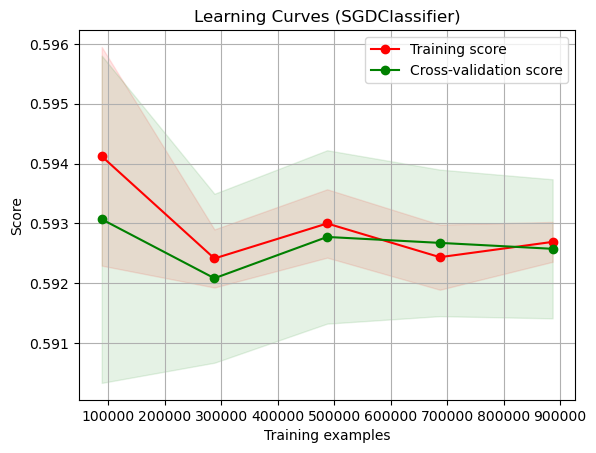

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Assuming you have X_train and y_train datasets
title = "Learning Curves (SGDClassifier)"
cv = 5  # Cross-validation folds

# Create an instance of the SGDClassifier
svm = SGDClassifier(loss='hinge')

# Plot the learning curve
plot_learning_curve(svm, title, X_train_approx, y_train, cv=cv)
plt.show()


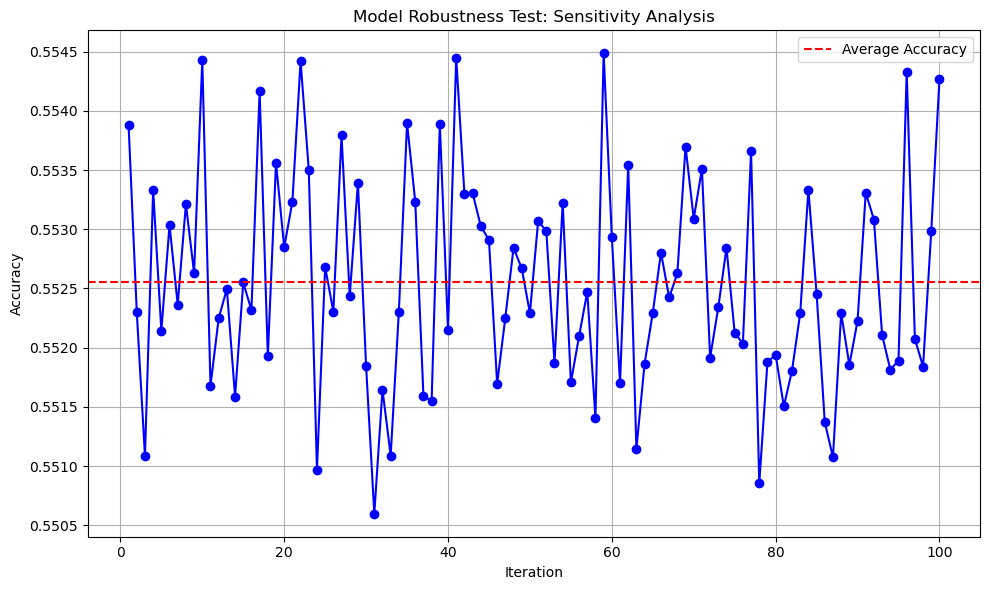

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Function to add perturbations to the data
def add_perturbations(X, magnitude=0.1):
    X_perturbed = X + np.random.normal(0, magnitude, X.shape)
    return X_perturbed

# Define the magnitude of the perturbations and the number of iterations
perturbation_magnitude = 0.1
num_iterations = 100

# Lists to store accuracy scores for each iteration
accuracies = []

# Perform multiple iterations of perturbations
for i in range(num_iterations):
    # Generate perturbed test data
    X_test_perturbed = add_perturbations(X_test_approx, magnitude=perturbation_magnitude)
    
    # Predict the target variable for the perturbed test data
    y_pred_perturbed = svm.predict(X_test_perturbed)
    
    # Calculate the accuracy for this iteration and store it
    accuracy_perturbed = accuracy_score(y_test, y_pred_perturbed)
    accuracies.append(accuracy_perturbed)

# Calculate the average accuracy
average_accuracy = np.mean(accuracies)

# Display the results on a graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_iterations + 1), accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=average_accuracy, color='r', linestyle='--', label='Average Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Robustness Test: Sensitivity Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





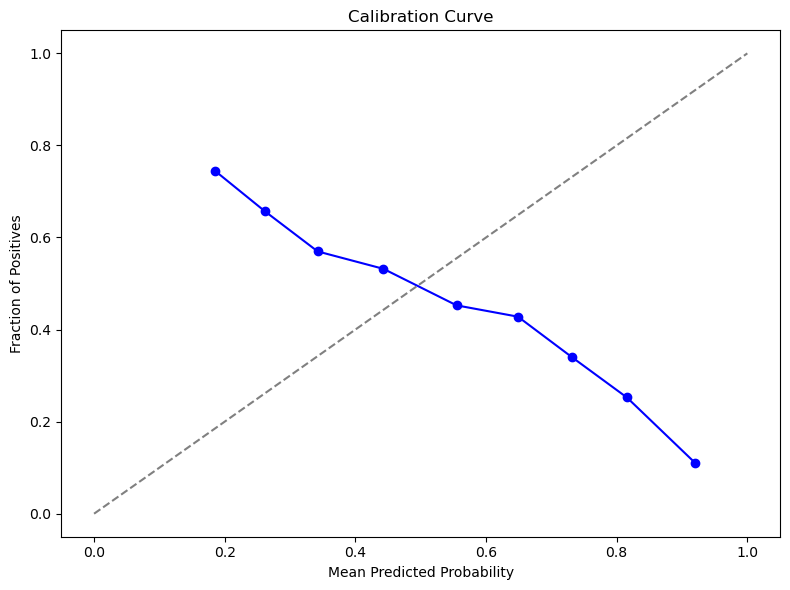

In [61]:
from sklearn.calibration import calibration_curve
y_scores = svm.decision_function(X_test_approx)

# Convert decision function scores to probabilities using Platt scaling
# Note: For SGDClassifier, probability=True is not supported during partial_fit,
# so we'll use Platt scaling to convert decision function scores to probabilities.
def platt_scaling(decision_scores):
    return 1 / (1 + np.exp(-decision_scores))

y_pred_prob = platt_scaling(y_scores)

# Assuming y_test contains the actual binary outcomes (0 or 1)
prob_true, prob_pred = calibration_curve(y_test_numeric, y_pred_prob, n_bins=10)

# Create a calibration plot
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')

plt.tight_layout()
plt.show();

#the points deviate significantly from the diagonal line, the model may suffer from calibration issues,
#and the predicted probabilities might need to be recalibrated.


In [25]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution to sample from
param_dist = {
    'alpha': stats.loguniform(1e-6, 1e-2),
    'penalty': ['l1', 'l2'],
    'max_iter': stats.randint(100, 5000),
}

# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=10, cv=4, random_state=42)
random_search.fit(X_train_approx, y_train)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_svm = random_search.best_estimator_

# Predict the target variable for the approximated test data
y_pred_test = best_svm.predict(X_test_approx)
y_pred_train = best_svm.predict(X_train_approx)
# Evaluate the model's accuracy

print("Best Hyperparameters:", best_params)
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("SVM Train Accuracy:", accuracy_score(y_train, y_pred_train))

Best Hyperparameters: {'alpha': 0.00027964859516062436, 'max_iter': 4943, 'penalty': 'l1'}
SVM Test Accuracy: 0.5994355502302551
SVM Train Accuracy: 0.5985159694784871


''''alpha': 0.00027964859516062436: This is the best value for the regularization parameter (alpha) found during the hyperparameter tuning process.
The value is very small, which indicates that the SVM model is using a relatively strong regularization to prevent overfitting.

'max_iter': 4943: This is the maximum number of iterations the SVM model performed during training.
It indicates how many iterations the model went through the training data to optimize the objective function (loss function) and find the optimal weights.

'penalty': 'l1': This specifies the regularization term used by the SVM model. 
'l1' refers to L1 regularization, which enforces sparsity in the feature weights.'''

In [19]:
classi_rep = classification_report(y_test, y_pred_test,zero_division=1)
print(classi_rep)

              precision    recall  f1-score   support

          Q1       0.59      0.67      0.63    139013
          Q2       0.62      0.54      0.57    138070

    accuracy                           0.60    277083
   macro avg       0.60      0.60      0.60    277083
weighted avg       0.60      0.60      0.60    277083



In [31]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred_test == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_test))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))

confusion matrix:
 [[77041 62012]
 [48978 89053]]
roc_auc_score: 0.5996036055752099


C:\Users\User\AppData\Local\Temp\ipykernel_5672\1488778724.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\1488778724.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\1488778724.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\1488778724.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\1488778724.py:22: DeprecationWarning: scipy.interp is deprecated and will be removed in 

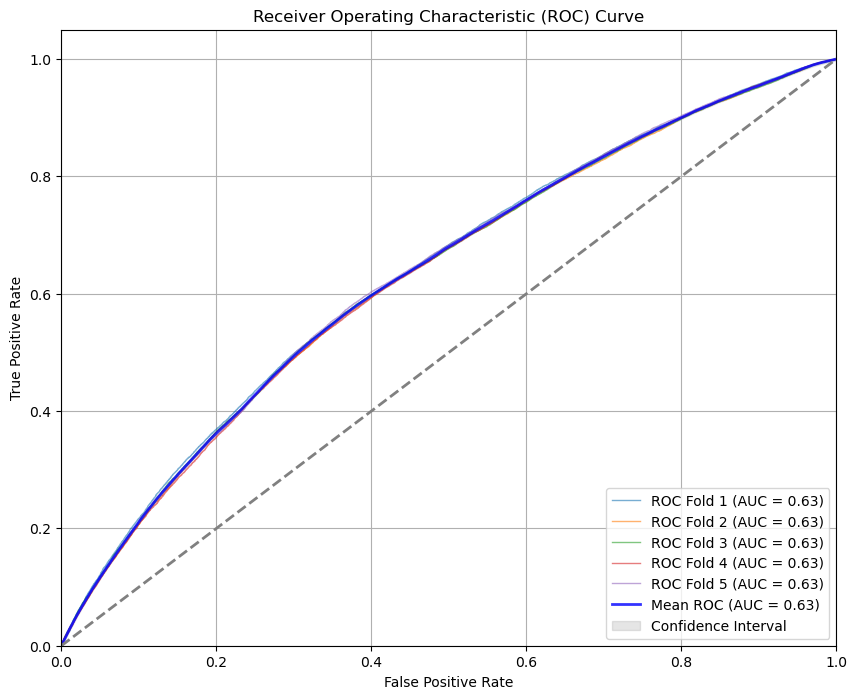

In [43]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)
# Calculate the ROC curve and confidence intervals using StratifiedKFold
cv = StratifiedKFold(n_splits=5)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for i, (train, test) in enumerate(cv.split(X_test_approx, y_test_numeric)):
    random_search.fit(X_test_approx[train], y_test_numeric[train])

    # Get the decision scores (not probabilities) for the test set
    decision_scores = random_search.decision_function(X_test_approx[test])
    
    # Compute ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test_numeric[test], decision_scores)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Plot the current fold's ROC curve
    plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

# Plot the mean ROC curve and confidence intervals
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label='Mean ROC (AUC = %0.2f)' % mean_auc)

# Shade the area between the confidence intervals
std_auc = np.std(aucs)
tpr_upper = np.minimum(mean_tpr + std_auc, 1)
tpr_lower = mean_tpr - std_auc
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2, label='Confidence Interval')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();

#the ROC curve plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at different classification thresholds.
#The AUC value represents the area under the ROC curve, and a higher AUC indicates better model performance.

C:\Users\User\AppData\Local\Temp\ipykernel_5672\2720380881.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\2720380881.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Users\User\AppData\Local\Temp\ipykernel_5672\2720380881.py:29: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))


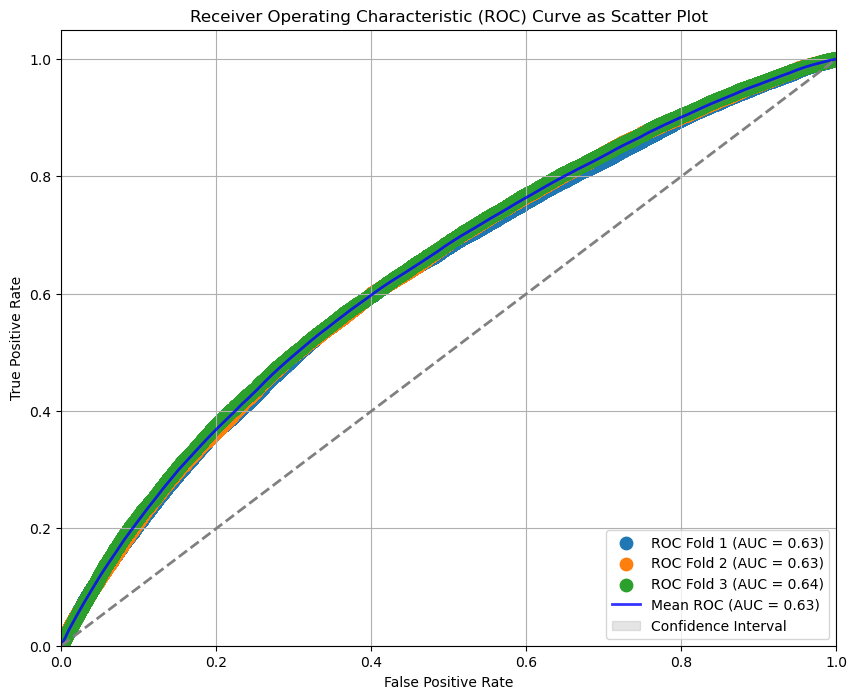

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp


# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test_numeric, y_pred_numeric)


# Calculate the ROC curve and confidence intervals using StratifiedKFold
cv = StratifiedKFold(n_splits=3)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))

for i, (train, test) in enumerate(cv.split(X_test_approx, y_test_numeric)):
    # Fit the model on the training data
    random_search.fit(X_test_approx[train], y_test_numeric[train])

    # Get the decision scores (not probabilities) for the test set
    decision_scores = random_search.decision_function(X_test_approx[test])

    # Compute ROC curve and AUC for the current fold
    fpr, tpr, thresholds = roc_curve(y_test_numeric[test], decision_scores)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)  # Ensure to import the `auc` function from sklearn.metrics
    aucs.append(roc_auc)

    # Plot the current fold's ROC curve as scatter plot
    plt.scatter(fpr, tpr, s=80, label='ROC Fold %d (AUC = %0.2f)' % (i + 1, roc_auc))

# Plot the mean ROC curve and confidence intervals
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', lw=2, alpha=0.8, label='Mean ROC (AUC = %0.2f)' % mean_auc)

# Shade the area between the confidence intervals
std_auc = np.std(aucs)
tpr_upper = np.minimum(mean_tpr + std_auc, 1)
tpr_lower = mean_tpr - std_auc
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='gray', alpha=0.2, label='Confidence Interval')

# Plot the random guessing line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve as Scatter Plot')
plt.legend(loc='lower right')
plt.grid(True)
plt.show();


**BAGGING**

In [21]:
from sklearn.ensemble import BaggingClassifier

# Create a BaggingClassifier with the SGDClassifier as the base estimator
bagging_svm = BaggingClassifier(base_estimator=svm, n_estimators=20, random_state=42)

# Fit the BaggingClassifier to the approximated training data
bagging_svm.fit(X_train_approx, y_train)

# Predict the target variable for the approximated test data using Bagging
y_pred_trainbag = bagging_svm.predict(X_test_approx)
y_pred_testbag = bagging_svm.predict(X_test_approx)

print("Bagging svm Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Bagging svm Train Accuracy:", accuracy_score(y_train, y_pred_train))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging svm Test Accuracy: 0.6029745599693954
Bagging svm Train Accuracy: 0.6030566653313267


In [30]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_numeric = np.where(y_pred_testbag == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_testbag))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_numeric))

confusion matrix:
 [[86054 52959]
 [59969 78101]]
roc_auc_score: 0.5923489874742345


**BOOSTING**

In [23]:
from sklearn.ensemble import AdaBoostClassifier

# Create an AdaBoostClassifier with the SGDClassifier as the base estimator and algorithm='SAMME'
adaboost_svm = AdaBoostClassifier(base_estimator=svm, n_estimators=50, random_state=42, algorithm='SAMME')

# Fit the AdaBoostClassifier to the approximated training data
adaboost_svm.fit(X_train_approx, y_train)

# Predict the target variable for the approximated test data using AdaBoost
y_pred_test_adaboost = adaboost_svm.predict(X_test_approx)
y_pred_train_adaboost = adaboost_svm.predict(X_train_approx)

print("Bagging svm Test Accuracy:", accuracy_score(y_test, y_pred_test_adaboost))
print("Bagging svm Train Accuracy:", accuracy_score(y_train, y_pred_train_adaboost))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging svm Test Accuracy: 0.5017016561824436
Bagging svm Train Accuracy: 0.5010168433285334


**KNN KNEIGHBORSCLASSIFIER **

In [11]:
data_knn = cleaned_df.drop(['AttendanceTimeSeconds','AttendanceTime'], axis =1)
target_knn = cleaned_df['AttendanceTime']


X_train, X_test, y_train, y_test = train_test_split(data_knn, target_knn, test_size=0.2, random_state=42)

# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)




# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




**PCA**

In [12]:
# PCA
pca = PCA(n_components=10)  

# Apply PCA on the train dataset
X_train = pca.fit_transform(X_train)

# Apply PCA on the test dataset
X_test = pca.transform(X_test)


knn = KNeighborsClassifier()  

# Fit the KNN model on the train dataset
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
print('knn test score:',knn.score(X_test, y_test))
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.6504381342841882
knn train score: 0.7746426389902674


**ROC AUC SCORE**

In [22]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_knnnumeric = np.where(y_pred_knn == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_knn))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_knnnumeric))

confusion matrix:
 [[95524 43529]
 [53329 84702]]
roc_auc_score: 0.6503029238696777


In [21]:
y_pred_knn = knn.predict(X_test)

classi_rep = classification_report(y_test, y_pred_knn)
print(classi_rep)

              precision    recall  f1-score   support

          Q1       0.64      0.69      0.66    139053
          Q2       0.66      0.61      0.64    138031

    accuracy                           0.65    277084
   macro avg       0.65      0.65      0.65    277084
weighted avg       0.65      0.65      0.65    277084



**COHEN KAPPA SCORE**

In [23]:
from sklearn.metrics import cohen_kappa_score

# Calculate the predicted labels for both train and test datasets
y_pred_knntrain = knn.predict(X_train)
 

# Calculate Cohen's Kappa for train and test datasets
kappa_train = cohen_kappa_score(y_train, y_pred_knntrain)
kappa_test = cohen_kappa_score(y_test, y_pred_knn)

# Print the results
print("Cohen's Kappa - Train:", kappa_train)
print("Cohen's Kappa - Test:", kappa_test)

Cohen's Kappa - Train: 0.5492225271467748
Cohen's Kappa - Test: 0.30068429914503136


Cohen's Kappa - Train: 0.5492 (moderate agreement). Cohen's Kappa - Test: 0.3007 (fair agreement).
Since the test set's Cohen's Kappa is lower than the train set, it's possible that the model may be overfitting to some extent.
 Cohen's Kappa coefficient, is a statistical measure used to assess the agreement between two raters or evaluators for categorical items

**BAGGING**

In [14]:
from sklearn.ensemble import BaggingClassifier
bagging_knn = BaggingClassifier(base_estimator=knn, n_estimators=10, random_state=42)

# Fit the BaggingClassifier to the data
bagging_knn.fit(X_train, y_train)

# Evaluate the bagging_knn model
print('Bagging KNN Test Score:', bagging_knn.score(X_test, y_test))
print('Bagging KNN Train Score:', bagging_knn.score(X_train, y_train))

C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Bagging KNN Test Score: 0.6486228003060444
Bagging KNN Train Score: 0.7800209864724771


        **END    **

In [9]:
# Create a new column "is_long_time" based on the threshold of 360 seconds
cleaned_df['AttendTime'] = cleaned_df['AttendanceTimeSeconds'] > 360

# Convert boolean values to 0 and 1
cleaned_df['AttendTime'] = cleaned_df['AttendTime'].astype(int)
cleaned_df.head()

CalYear  TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
2     2009         180           0           533750            194450   
3     2009         267           0           507750            182850   
4     2009         339           0           531050            185350   
6     2009         363           0           529450            185250   
8     2009         751           0           541050            175650   

   AttendanceTimeSeconds  Day  Month  WeekDay  IncidentGroup_False Alarm  \
2                    308    1      1        3                          0   
3                    210    1      1        3                          0   
4                    233    1      1        3                          0   
6                    172    1      1        3                          1   
8                    522    1      1        3                          0   

   IncidentGroup_Fire  IncidentGroup_Special Service  \
2                   1                              0   
3                   1                              0   
4                   1                              0   
6                   0                              0   
8                   0                              1   

   SpecialServiceType_Advice Only  \
2                               0   
3                               0   
4                               0   
6                               0   
8                               0   

   SpecialServiceType_Animal assistance incidents  \
2                                               0   
3                                               0   
4                                               0   
6                                               0   
8                                               0   

   SpecialServiceType_Assist other agencies  \
2                                         0   
3                                         0   
4                                         0   
6                                         0   
8                                         0   

   SpecialServiceType_Effecting entry/exit  \
2                                        0   
3                                        0   
4                                        0   
6                                        0   
8                                        0   

   SpecialServiceType_Evacuation (no fire)  SpecialServiceType_Flooding  \
2                                        0                            0   
3                                        0                            0   
4                                        0                            0   
6                                        0                            0   
8                                        0                            0   

   SpecialServiceType_Hazardous Materials incident  \
2                                                0   
3                                                0   
4                                                0   
6                                                0   
8                                                0   

   SpecialServiceType_Lift Release  SpecialServiceType_Making Safe (not RTC)  \
2                                0                                         0   
3                                0                                         0   
4                                0                                         0   
6                                0                                         0   
8                                0                                         0   

   SpecialServiceType_Medical Incident  \
2                                    0   
3                                    0   
4                                    0   
6                                    0   
8                                    0   

   SpecialServiceType_Medical Incident - Co-responder  \
2                                                  0    
3                                           

In [14]:
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

# Create a Nystroem transformer object
nystroem = Nystroem(kernel='rbf')

# Approximate the kernel matrix
X_train_approx = nystroem.fit_transform(X_train)
X_test_approx = nystroem.transform(X_test)

# Create an SGDClassifier object
svm = SGDClassifier(loss='hinge')

# Fit the classifier to the approximated training data
svm.partial_fit(X_train_approx, y_train, classes=np.unique(y_train))

# Predict the target variable for the approximated test data
y_pred = svm.predict(X_test_approx)

print('svm test score:',svm.score(X_test_approx,y_test))  
print('svm train score:',svm.score(X_train_approx,y_train))

classi_rep = classification_report(y_test, y_pred,zero_division=1)
print('classification report:\n\n',classi_rep)

print('confusion matrix:\n',confusion_matrix(y_test, y_pred))
print('roc_auc_score:',roc_auc_score(y_test, y_pred))

svm test score: 0.7072295765904925
svm train score: 0.7080128445151412
classification report:

               precision    recall  f1-score   support

           0       0.71      1.00      0.83    195962
           1       1.00      0.00      0.00     81122

    accuracy                           0.71    277084
   macro avg       0.85      0.50      0.41    277084
weighted avg       0.79      0.71      0.59    277084

confusion matrix:
 [[195962      0]
 [ 81122      0]]
roc_auc_score: 0.5


In [21]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)


In [22]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
 print('svm test score:',svm.score(X_test_approx,y_test))  
print('svm train score:',svm.score(X_train_approx,y_train))

svm test score: 0.6006878780442032
svm train score: 0.599993864659809


In [54]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
# Assuming you want to select the top k features
k = 10

# Compute the F-test scores for each feature
f_test = SelectKBest(score_func=f_classif, k=k)
X_train_selected = f_test.fit_transform(X_train_approx, y_train)
X_test_selected = f_test.transform(X_test_approx)
selected_feature_indices = f_test.get_support(indices=True)
# Assuming you have a DataFrame 'df' and 'selected_feature_indices' from the previous step
selected_feature_names = cleaned_df.columns[selected_feature_indices]

# Display the selected feature names
print(selected_feature_names)

print(selected_feature_indices)

Index(['Northing_rounded', 'SpecialServiceType_Assist other agencies',
       'SpecialServiceType_Suicide/attempts', 'PropertyCategory_Boat',
       'PropertyCategory_Outdoor Structure', 'ProperCase_Camden',
       'ProperCase_Greenwich', 'ProperCase_Hillingdon',
       'ProperCase_Kingston Upon thames', 'IncidentStationGround_Chingford'],
      dtype='object')
[ 4 14 32 35 40 48 53 59 63 88]


In [15]:
y_pred_knnbagging = bagging_knn.predict(X_test)
y_pred_knnbaggingtrain = bagging_knn.predict(X_train)

classification_report(y_test, y_pred_knnbagging)
print(classification_report(y_test, y_pred_knnbagging))

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score
y_test_numeric = np.where(y_test == 'Q1', 1, 0)
y_pred_knnnumericbag = np.where(y_pred_knnbagging == 'Q1', 1, 0)


print('confusion matrix:\n',confusion_matrix(y_test, y_pred_knnbagging))
print('roc_auc_score:',roc_auc_score(y_test_numeric, y_pred_knnnumericbag))

In [17]:
# Define the hyperparameter space for grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Evaluate on the test set
y_predcv = best_estimator.predict(X_test)
print('best knn test score:',knn.score(X_test, y_test))
print('best knn train score:',knn.score(X_train, y_train))

KeyboardInterrupt: 

In [ ]:
y_pred_knntraincv = best_estimator.predict(X_train)
#y_pred_knntestcv = best_estimator.predict(X_test)

print(classification_report(y_test, y_pred_knntestcv))

In [13]:
print('knn test score:',knn.score(X_test, y_test))
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.6479984409060069
knn train score: 0.7727406835310326


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("KNN Regression Mean Squared Error:", mean_squared_error(y_test, y_pred))# Calculate Mean Squared Error (MSE)


print("KNN Regression Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))# Calculate Root Mean Squared Error (RMSE)


print("KNN Regression Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))# Calculate Mean Absolute Error (MAE)


print("KNN Regression R-squared (coefficient of determination):", r2_score(y_test, y_pred))# Calculate R-squared (coefficient of determination)

KNN Regression Mean Squared Error: 13354.533454996863
KNN Regression Root Mean Squared Error (RMSE): 115.56181659612686
KNN Regression Mean Absolute Error (MAE): 79.85154243479253
KNN Regression R-squared (coefficient of determination): 0.23589796779518546


In [42]:
# Create KNN regressor
knn_regressor = KNeighborsRegressor()

# Define the hyperparameter space for grid search
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],  
    'weights': ['uniform', 'distance'],  
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Evaluate on the test set
y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best KNN Regression Mean Squared Error (MSE) on Test Set:", mse)

Best Hyperparameters: {'n_neighbors': 9, 'weights': 'uniform'}
Best KNN Regression Mean Squared Error (MSE) on Test Set: 12506.885038482922


In [43]:

data_svmreg = cleaned_df.drop(['AttendanceTimeSeconds','AttendanceTime'], axis =1)
target_svmreg = cleaned_df['AttendanceTimeSeconds']

X_train, X_test, y_train, y_test = train_test_split(data_svmreg, target_svmreg, test_size=0.2, random_state=42)


In [44]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)

In [45]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [60]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

# Create the Nystroem kernel approximation with the appropriate parameters
nystroem_approximation = Nystroem(kernel='rbf', n_components=100, random_state=42)

# Apply Nystroem approximation to the training data
X_train_nystroem = nystroem_approximation.fit_transform(X_train)

# Apply Nystroem approximation to the test data
X_test_nystroem = nystroem_approximation.transform(X_test)

# Create the SGDRegressor with the appropriate parameters
sgd_regressor = SGDRegressor(loss='squared_error', alpha=0.0001, random_state=42)

# Fit the SGDRegressor model on the training data
sgd_regressor.fit(X_train_nystroem, y_train)

# Make predictions on the test data
y_pred = sgd_regressor.predict(X_test_nystroem)

# Calculate Mean Squared Error (MSE) for evaluation
mse = mean_squared_error(y_test, y_pred)
print("SGDRegressor Mean Squared Error (MSE):", mse)

SGDRegressor Mean Squared Error (MSE): 16473.823455581893


In [3]:
merged_df['PerformanceReporting'] = merged_df['PerformanceReporting'].replace('Not Used', 3).astype(int)

In [75]:
#DeployedFromStation_Code(A39)+one_digit == Resouce_Code(A392)
#keeping resouce_code coz it has no missing values and can also get DeployedFromStation_Code from it
merged_df['IncGeo_WardNameNew'].nunique()


1478

In [71]:
# IncGeo_BoroughName == ProperCase both have 33 nunique values, dtype: O
merged_df['IncGeo_BoroughName'].unique()

array(['WANDSWORTH', 'ENFIELD', 'HILLINGDON', 'ISLINGTON', 'CAMDEN',
       'GREENWICH', 'HOUNSLOW', 'SOUTHWARK', 'HACKNEY', 'CITY OF LONDON',
       'BROMLEY', 'MERTON', 'KENSINGTON AND CHELSEA', 'NEWHAM', 'LAMBETH',
       'REDBRIDGE', 'TOWER HAMLETS', 'WALTHAM FOREST', 'LEWISHAM',
       'WESTMINSTER', 'CROYDON', 'RICHMOND UPON THAMES', 'BARNET',
       'BRENT', 'HARINGEY', 'BEXLEY', 'BARKING AND DAGENHAM',
       'HAMMERSMITH AND FULHAM', 'HAVERING', 'EALING',
       'KINGSTON UPON THAMES', 'SUTTON', 'HARROW'], dtype=object)

In [11]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)  # To display all columns
display(merged_df[merged_df['Year'] == 2020])

IncidentNumber DateOfCall  CalYear  TimeOfCall  HourOfCall  \
1630589  000003-01012020 2020-01-01     2020         390           0   
1630590  000003-01012020 2020-01-01     2020         390           0   
1630591  000008-01012020 2020-01-01     2020         665           0   
1630592  000009-01012020 2020-01-01     2020         676           0   
1630593  000011-01012020 2020-01-01     2020         722           0   
...                  ...        ...      ...         ...         ...   
1780358  164506-31122020 2020-12-31     2020       85940          23   
1780359  164508-31122020 2020-12-31     2020       86030          23   
1780360  164509-31122020 2020-12-31     2020       86072          23   
1780361  164510-31122020 2020-12-31     2020       86219          23   
1780362  164510-31122020 2020-12-31     2020       86219          23   

           IncidentGroup        StopCodeDescription SpecialServiceType  \
1630589             Fire               Primary Fire                NaN   
1630590             Fire               Primary Fire                NaN   
1630591      False Alarm                        AFA                NaN   
1630592             Fire             Secondary Fire                NaN   
1630593      False Alarm                        AFA                NaN   
...                  ...                        ...                ...   
1780358             Fire             Secondary Fire                NaN   
1780359             Fire             Secondary Fire                NaN   
1780360      False Alarm  False alarm - Good intent                NaN   
1780361  Special Service            Special Service           Flooding   
1780362  Special Service            Special Service           Flooding   

          PropertyCategory                                       PropertyType  \
1630589    Non Residential                               Private Garden Shed    
1630590    Non Residential                               Private Garden Shed    
1630591    Non Residential                                 Telephone exchange   
1630592  Outdoor Structure                     Small refuse/rubbish container   
1630593  Other Residential                        Retirement/Old Persons Home   
...                    ...                                                ...   
1780358            Outdoor                                      Loose refuse    
1780359  Outdoor Structure                   Common external bin storage area   
1780360           Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
1780361           Dwelling                          House - single occupancy    
1780362           Dwelling                          House - single occupancy    

                              AddressQualifier Postcode_full  \
1630589       On land associated with building           NaN   
1630590       On land associated with building           NaN   
1630591              Correct incident location       TW9 1LW   
1630592       On land associated with building        N9 8NB   
1630593                   Within same building      SW17 9JH   
...                                        ...           ...   
1780358  In street close to gazetteer location      WC2B 5JF   
1780359       On land associated with building        W2 1LN   
1780360              Correct incident location           NaN   
1780361              Correct incident location           NaN   
1780362              Correct incident location           NaN   

        Postcode_district          UPRN        USRN IncGeo_BoroughCode  \
1630589               UB8  0.000000e+00  21402055.0          E09000017   
1630590               UB8  0.000000e+00  21402055.0          E09000017   
1630591               TW9  1.000225e+10  22403714.0          E09000027   
1630592                N9  2.070908e+08  20703225.0          E09000010   
1630593              SW17  1.210367e+08  22903376.0          E09000032   
...                   ...           ...         ...                ...

In [5]:
#-----execute-----#

merged_df[['Date', 'TimeArrived']] = merged_df['DateAndTimeArrived'].str.split(' ', expand=True)
merged_df[['Date', 'TimeMobilised']] = merged_df['DateAndTimeMobilised'].str.split(' ', expand=True)
merged_df[['Date', 'TimeMobile']] = merged_df['DateAndTimeMobile'].str.split(' ', expand=True)
merged_df[['Date', 'TimeLeft']] = merged_df['DateAndTimeLeft'].str.split(' ', expand=True)
merged_df[['Date', 'TimeReturned']] = merged_df['DateAndTimeReturned'].str.split(' ', expand=True)

In [6]:
#-----execute-----#

merged_df['TimeArrived'] = pd.to_timedelta(merged_df['TimeArrived']).dt.total_seconds()
merged_df['TimeMobilised'] = pd.to_timedelta(merged_df['TimeMobilised']).dt.total_seconds()
merged_df['TimeMobile'] = pd.to_timedelta(merged_df['TimeMobile']).dt.total_seconds()
merged_df['TimeLeft'] = pd.to_timedelta(merged_df['TimeLeft']).dt.total_seconds()
merged_df['TimeReturned'] = pd.to_timedelta(merged_df['TimeReturned']).dt.total_seconds()

In [37]:
#replace NAN values of TravelTimeSeconds with AttendanceTimeSeconds
#replace NAN values of TurnoutTimeSeconds with 0
merged_df['TravelTimeSeconds'] = merged_df['TravelTimeSeconds']\
                      .fillna(merged_df['AttendanceTimeSeconds'])

merged_df['TurnoutTimeSeconds'] = merged_df['TurnoutTimeSeconds'].fillna(0)


In [34]:
#nunique values of object datatypes
#IncidentGroup = 3,ProperCase = 33,PropertyCategory = 9,IncGeo_WardNameNew = 1478,IncidentStationGround = 102
#Resource_Code = 187,PlusCode_Description = 3
cleaned_df['PropertyCategory'].unique()

array(['Road Vehicle', 'Outdoor', 'Dwelling', 'Other Residential',
       'Non Residential', 'Aircraft', 'Rail Vehicle', 'Boat'],
      dtype=object)

In [8]:
#after replacing now the nunique value is 8
cleaned_df['PropertyCategory'] = cleaned_df['PropertyCategory'].replace('Outdoor Structure', 'Outdoor')

In [11]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 80)
print(pd.concat([cleaned_df.isnull().sum(), cleaned_df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))


                               Missing Values Data Types
TimeOfCall                                  0      int32
HourOfCall                                  0      int64
IncidentGroup                               0     object
SpecialServiceType                          0     object
PropertyCategory                            0     object
ProperCase                                  0     object
Easting_rounded                             0      int64
Northing_rounded                            0      int64
IncidentStationGround                       0     object
NumStationsWithPumpsAttending               0    float64
NumPumpsAttending                           0    float64
PumpCount                                   0    float64
ResourceMobilisationId                      0      int64
TurnoutTimeSeconds                          0    float64
TravelTimeSeconds                           0    float64
AttendanceTimeSeconds                       0      int64
PumpOrder                      

In [57]:
#pd.set_option('display.max_rows', 100)
#pd.set_option('display.max_columns', 50)  # To display all columns
m = cleaned_df[cleaned_df['Year'] == 2014]
display(m.head())


IncidentNumber  TimeOfCall  HourOfCall IncidentGroup PropertyCategory  \
772865          12141         865           0          Fire         Dwelling   
772866          35141        1701           0   False Alarm         Dwelling   
772867          35141        1701           0   False Alarm         Dwelling   
772868          43141        1790           0          Fire          Outdoor   
772869          45141        1875           0          Fire         Dwelling   

                    ProperCase  Easting_rounded  Northing_rounded  \
772865                Hounslow           513450            175750   
772866                  Harrow           515550            189650   
772867                  Harrow           515550            189650   
772868               Redbridge           545750            187050   
772869  Kensington And chelsea           524250            180950   

       IncidentStationGround  FirstPumpArriving_AttendanceTime  \
772865                Heston                            1040.0   
772866              Stanmore                             429.0   
772867              Stanmore                             429.0   
772868                Ilford                             311.0   
772869      North Kensington                             183.0   

        NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
772865                            2.0                3.0        3.0   
772866                            2.0                2.0        2.0   
772867                            2.0                2.0        2.0   
772868                            1.0                1.0        1.0   
772869                            3.0                3.0        3.0   

        ResourceMobilisationId  TurnoutTimeSeconds  TravelTimeSeconds  \
772865                 4235579               130.0              910.0   
772866                 4235589                70.0              359.0   
772867                 4235588               146.0              318.0   
772868                 4235587                94.0              217.0   
772869                 4235596                72.0              111.0   

        AttendanceTimeSeconds  PumpOrder  PlusCode_Description  Day  Month  \
772865                   1040          1  Initial Mobilisation    1      1   
772866                    429          1  Initial Mobilisation    1      1   
772867                    464          2  Initial Mobilisation    1      1   
772868                    311          1  Initial Mobilisation    1      1   
772869                    183          1  Initial Mobilisation    1      1   

        Year  WeekDay  TimeArrived  TimeMobilised  
772865  2014        2       1944.0          904.0  
772866  2014        2       2271.0         1842.0  
772867  2014        2       2306.0         1842.0  
772868  2014        2       2133.0         1822.0  
772869  2014        2       2230.0         2047.0

In [49]:
#np.set_printoptions(threshold=np.inf) 
#cleaned_df['AttendanceTimeSeconds'].unique()
cleaned_df.loc[cleaned_df.AttendanceTimeSeconds.idxmin()]

IncidentNumber                             174855-21122015
TimeOfCall                                           25716
HourOfCall                                               7
IncidentGroup                              Special Service
PropertyCategory                                  Dwelling
ProperCase                          Kensington And chelsea
Easting_rounded                                     524150
Northing_rounded                                    181950
IncidentStationGround                     North Kensington
FirstPumpArriving_AttendanceTime                       0.0
NumStationsWithPumpsAttending                          1.0
NumPumpsAttending                                      1.0
PumpCount                                              1.0
ResourceMobilisationId                             4615486
TurnoutTimeSeconds                                     NaN
TravelTimeSeconds                                      NaN
AttendanceTimeSeconds                                   

In [38]:
cleaned_df['TimeOfCall'] =round(cleaned_df['TimeOfCall'] / 60)
cleaned_df['TurnoutTimeSeconds'] =round(cleaned_df['TurnoutTimeSeconds'] / 60)
cleaned_df['TravelTimeSeconds'] =round(cleaned_df['TravelTimeSeconds'] / 60)
cleaned_df['AttendanceTimeSeconds'] =round(cleaned_df['AttendanceTimeSeconds'] / 60)
cleaned_df['TimeArrived'] =round(cleaned_df['TimeArrived'] / 60)
cleaned_df['TimeMobilised'] =round(cleaned_df['TimeMobilised'] / 60)
cleaned_df['FirstPumpArriving_AttendanceTime'] =round(cleaned_df['FirstPumpArriving_AttendanceTime'] / 60)

In [48]:
cleaned_df[['TimeOfCall','TurnoutTimeSeconds','TravelTimeSeconds','AttendanceTimeSeconds','TimeArrived','TimeMobilised',
          'FirstPumpArriving_AttendanceTime']]=cleaned_df[['TimeOfCall','TurnoutTimeSeconds','TravelTimeSeconds',
                                                           'AttendanceTimeSeconds','TimeArrived','TimeMobilised',
          'FirstPumpArriving_AttendanceTime']].astype(int)

In [72]:
cleaned_df['AttendanceTimeSeconds'].unique()

array([ 5,  6,  4,  3,  9, 10,  1, 12, 11,  2,  7,  8, 14, 13, 19, 16, 17,
       15, 18,  0, 20])

In [10]:
#-----execute-----#



df.shape

(1436122, 23)

In [16]:
#quartiles = np.quantile(df['AttendanceTimeSeconds'], [0.25, 0.5, 0.75])

# Divide the "AttendanceTime" column into 4 equal parts based on quartiles
df['AttendanceTimeSeconds'] = pd.qcut(df['AttendanceTimeSeconds'], labels=['Q1', 'Q2', 'Q3', 'Q4'], q=4)

In [72]:
df['TimeOfCall'] =round(df['TimeOfCall'] / 60)
df['TurnoutTimeSeconds'] =round(df['TurnoutTimeSeconds'] / 60)
df['TravelTimeSeconds'] =round(df['TravelTimeSeconds'] / 60)
df['AttendanceTimeSeconds'] =round(df['AttendanceTimeSeconds'] / 60)
df['TimeArrived'] =round(df['TimeArrived'] / 60)
df['TimeMobilised'] =round(df['TimeMobilised'] / 60)

In [74]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
print(pd.concat([df.isnull().sum(), df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))

                               Missing Values Data Types
TimeOfCall                                  0      int32
HourOfCall                                  0      int64
IncidentGroup                               0     object
PropertyCategory                            0     object
ProperCase                                  0     object
Easting_rounded                             0      int64
Northing_rounded                            0      int64
IncidentStationGround                       0     object
NumStationsWithPumpsAttending               0    float64
NumPumpsAttending                           0    float64
PumpCount                                   0    float64
ResourceMobilisationId                      0      int64
TurnoutTimeSeconds                          0      int32
TravelTimeSeconds                           0      int32
AttendanceTimeSeconds                       0      int32
PumpOrder                                   0      int64
PlusCode_Description           

In [13]:
#help(pd.get_dummies)
#df['AttendanceTimeSeconds'].nunique()

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [59]:
#df = np.reshape(df, (-1, 1))
#cleaned_df['AttendanceTime'] = pd.qcut(cleaned_df['AttendanceTimeSeconds'], q=4, labels=['Q1', 'Q2','Q3','Q4'])


In [36]:
df['AttendanceTime'].value_counts()# then it is balanced 

Q1    684598
Q2    679717
Name: AttendanceTime, dtype: int64

In [57]:
df.head()

TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
0          37           0           528650            176850   
2         180           0           533750            194450   
3         267           0           507750            182850   
4         339           0           531050            185350   
6         363           0           529450            185250   

   NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
0                            2.0                2.0        2.0   
2                            1.0                1.0        1.0   
3                            1.0                1.0        1.0   
4                            1.0                2.0        2.0   
6                            1.0                2.0        2.0   

   ResourceMobilisationId  TurnoutTimeSeconds  TravelTimeSeconds  \
0                   38426                 0.0              319.0   
2                   38429               151.0              157.0   
3                   38430               108.0              102.0   
4                   38432               114.0              119.0   
6                   38434                83.0               89.0   

   AttendanceTimeSeconds  PumpOrder  Day  Month  Year  WeekDay  TimeArrived  \
0                    319          1    1      1  2009        3        466.0   
2                    308          1    1      1  2009        3        557.0   
3                    210          1    1      1  2009        3        507.0   
4                    233          1    1      1  2009        3        597.0   
6                    172          1    1      1  2009        3        562.0   

   TimeMobilised  IncidentGroup_False Alarm  IncidentGroup_Fire  \
0          147.0                          0                   0   
2          249.0                          0                   1   
3          297.0                          0                   1   
4          364.0                          0                   1   
6          390.0                          1                   0   

   IncidentGroup_Special Service  PropertyCategory_Aircraft  \
0                              1                          0   
2                              0                          0   
3                              0                          0   
4                              0                          0   
6                              0                          0   

   PropertyCategory_Boat  PropertyCategory_Dwelling  \
0                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   
6                      0                          1   

   PropertyCategory_Non Residential  PropertyCategory_Other Residential  \
0                                 0                                   0   
2                                 0                                   0   
3                                 0                                   0   
4                                 0                                   0   
6                                 0                                   0   

   PropertyCategory_Outdoor  PropertyCategory_Rail Vehicle  \
0                         0                              0   
2                         1                              0   
3                         1                              0   
4                         1                              0   
6                         0                              0   

   PropertyCategory_Road Vehicle  ProperCase_Barking And dagenham  \
0                              1                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   
6                              0                       

In [38]:
 print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8386665506136304


In [39]:
classi_rep = classification_report(y_test, y_pred,zero_division=1)
print(classi_rep)

              precision    recall  f1-score   support

          Q1       0.85      0.82      0.83    143242
          Q2       0.83      0.86      0.84    143983

    accuracy                           0.84    287225
   macro avg       0.84      0.84      0.84    287225
weighted avg       0.84      0.84      0.84    287225



In [18]:
print('svm score:',svm.score(X_test_approx,y_test))

svm score: 0.8465090539941289


In [19]:
classi_rep = classification_report(y_test, y_pred,zero_division=1)
print(classi_rep)

              precision    recall  f1-score   support

          Q1       0.81      0.90      0.85    136622
          Q2       0.89      0.79      0.84    136241

    accuracy                           0.85    272863
   macro avg       0.85      0.85      0.85    272863
weighted avg       0.85      0.85      0.85    272863



In [36]:
 print('svm test score:',svm.score(X_test_approx,y_test))  
print('svm train score:',svm.score(X_train_approx,y_train))# with updated columns deleted with q=2

svm test score: 0.5898372356166768
svm train score: 0.5879943981053132


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          Q1       0.61      0.50      0.55    143242
          Q2       0.58      0.68      0.62    143983

    accuracy                           0.59    287225
   macro avg       0.59      0.59      0.59    287225
weighted avg       0.59      0.59      0.59    287225



In [50]:
print('svm test score:',svm.score(X_test_approx,y_test))  # with updated columns deleted with q=4
print('svm train score:',svm.score(X_train_approx,y_train))

svm test score: 0.2875306815214553
svm train score: 0.2875027091201387


In [64]:
print('svm test score:',svm.score(X_test_approx,y_test))  # with updated columns and specialservicetype deleted with q=2
print('svm train score:',svm.score(X_train_approx,y_train))

svm test score: 0.5937296544520846
svm train score: 0.5926197039421288


In [65]:
print('svm test score:',svm.score(X_test_approx,y_test))  # with specialservicetype and time related columns
print('svm train score:',svm.score(X_train_approx,y_train))

svm test score: 0.8264983897641222
svm train score: 0.8260000678912035


In [54]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform univariate feature selection
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train_approx, y_train)
X_test_selected = selector.transform(X_test_approx)

In [55]:
svm.fit(X_train_selected, y_train)
y_pred = svm.predict(X_test_selected)


In [56]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print('svm score:',svm.score(X_test_selected,y_test))

Accuracy: 0.628799721472713
svm score: 0.628799721472713


In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'penalty': ['l1', 'l2'],
    'max_iter': randint(100, 1000),
}

# Create an SGDClassifier object
svm = SGDClassifier(loss='hinge')

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(svm, param_distributions=param_grid, n_iter=10, cv=5)

# Fit the classifier to the approximated training data with hyperparameter tuning
random_search.fit(X_train_approx, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Predict the target variable for the approximated test data
y_pred = best_model.predict(X_test_approx)


KeyboardInterrupt: 

In [ ]:
from sklearn.neighbors import BallTree

# Assuming X_train is your training feature matrix
ball_tree = BallTree(X_train)

# Assuming X_test is your testing feature matrix and k is the number of neighbors
distances, indices = ball_tree.query(X_test, k=7)

# Retrieve the predicted labels for each test sample
y_pred = []
for i in range(len(indices)):
    nearest_labels = y_train[indices[i]]
    unique_labels, counts = np.unique(nearest_labels, return_counts=True)
    predicted_label = unique_labels[np.argmax(counts)]
    y_pred.append(predicted_label)

In [26]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [82]:
#df['AttendanceTime'] = pd.qcut(df['AttendanceTimeSeconds'], q=2, labels=['Q1', 'Q2'])



In [83]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  # Adjust the threshold value if needed

# Apply variance threshold on the train dataset
X_train = selector.fit_transform(X_train)

# Apply variance threshold on the test dataset
X_test = selector.transform(X_test)

In [84]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [85]:
#-----execute-----#



In [86]:
#-----execute-----#

knn = KNeighborsClassifier()  

# Fit the KNN model on the train dataset
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [45]:
###### -----execute-----#

print('knn score:',knn.score(X_test, y_test))#for pca 10

knn score: 0.7734772390982679


In [31]:
print('knn score:',knn.score(X_test, y_test))#for pca 10

knn score: 0.742544793541081


In [55]:
y_pred = knn.predict(X_test)
print('knn accuracy:', accuracy_score(y_test,y_pred))# with updated deleted columns

knn accuracy: 0.6656710510402656


In [21]:
print('knn test score:',knn.score(X_test, y_test))# with specialservicetype and time related columns
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.7502619897293062
knn train score: 0.8506245555519772


In [44]:
print('knn test score:',knn.score(X_test, y_test))# with updated deleted columns and q=2
print('knn train score:',knn.score(X_train, y_train))



knn test score: 0.6636469666637653
knn train score: 0.7845403025684635


In [56]:
print('knn test score:',knn.score(X_test, y_test))# with updated deleted columns and q=4
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.401702498041605
knn train score: 0.5987655986567987


In [70]:
print('knn test score:',knn.score(X_test, y_test))# with updated and specialservicetype deleted columns and q=2
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.666188528157368
knn train score: 0.7873934739145458


In [81]:
print('knn test score:',knn.score(X_test, y_test))# with updated and specialservicetype deleted columns and q=2 with knn 10
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.6735137958046827
knn train score: 0.7499401599969362


In [87]:
print('knn test score:',knn.score(X_test, y_test))# with updated and specialservicetype deleted columns and q=2 with knn without n_neighbors
print('knn train score:',knn.score(X_train, y_train))

knn test score: 0.6652067194707981
knn train score: 0.7869478290917289


In [91]:
classi_rep = classification_report(y_test, y_pred)
print(classi_rep)

              precision    recall  f1-score   support

           1       0.11      0.06      0.08      2029
           2       0.21      0.18      0.19     10421
           3       0.31      0.38      0.34     34950
           4       0.33      0.44      0.38     61020
           5       0.30      0.34      0.32     59364
           6       0.27      0.24      0.25     43463
           7       0.23      0.15      0.18     25151
           8       0.20      0.10      0.13     14432
           9       0.17      0.06      0.09      7762
          10       0.19      0.06      0.09      4585
          11       0.16      0.04      0.07      2690
          12       0.13      0.03      0.05      1664
          13       0.16      0.03      0.04      1104
          14       0.14      0.02      0.04       725
          15       0.18      0.03      0.05       440
          16       0.31      0.03      0.06       319
          17       0.18      0.02      0.03       188
          18       0.20    

In [26]:
data_knn

TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
0                37           0           528650            176850   
1               180           0           533750            194450   
2               267           0           507750            182850   
3               339           0           531050            185350   
4               363           0           529450            185250   
...             ...         ...              ...               ...   
1436117         297           0           504950            175450   
1436118         361           0           533650            189750   
1436119         534           0           534150            175850   
1436120        2508           0           525950            172050   
1436121        2892           0           541050            179850   

         NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
0                                  2.0                2.0        2.0   
1                                  1.0                1.0        1.0   
2                                  1.0                1.0        1.0   
3                                  1.0                2.0        2.0   
4                                  1.0                2.0        2.0   
...                                ...                ...        ...   
1436117                            1.0                1.0        1.0   
1436118                            2.0                2.0        2.0   
1436119                            1.0                1.0        1.0   
1436120                            1.0                1.0        1.0   
1436121                            1.0                1.0        1.0   

         ResourceMobilisationId  TurnoutTimeSeconds  TravelTimeSeconds  \
0                         38426                 0.0              319.0   
1                         38429               151.0              157.0   
2                         38430               108.0              102.0   
3                         38432               114.0              119.0   
4                         38434                83.0               89.0   
...                         ...                 ...                ...   
1436117                 6336951                27.0              421.0   
1436118                 6336952               109.0              167.0   
1436119                 6336954                87.0              288.0   
1436120                 6336955                83.0              319.0   
1436121                 6336956                71.0              419.0   

         PumpOrder  Day  Month  Year  WeekDay  TimeArrived  TimeMobilised  \
0                1    1      1  2009        3        466.0          147.0   
1                1    1      1  2009        3        557.0          249.0   
2                1    1      1  2009        3        507.0          297.0   
3                1    1      1  2009        3        597.0          364.0   
4                1    1      1  2009        3        562.0          390.0   
...            ...  ...    ...   ...      ...          ...            ...   
1436117          1    1      4  2023        5      83546.0        83098.0   
1436118          1    1      4  2023        5      83437.0        83161.0   
1436119          1    1      4  2023        5      83709.0        83334.0   
1436120          1    1      4  2023        5      85710.0        85308.0   
1436121          1    1      4  2023        5      86182.0        85692.0   

         IncidentGroup_False Alarm  IncidentGroup_Fire  \
0                                0                   0   
1                                0                   1   
2                                0                   1   
3                                0                   1   
4                                1                   0   
...                            ...                 ...   
1436117                          1                   0   
1436118                  

In [44]:

from annoy import AnnoyIndex
from sklearn.datasets import make_classification


# Generate a random classification dataset
data, target = make_classification(n_samples=10000, n_features=20, random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Build the Annoy index
n_trees = 100  # Number of trees in the index
index = AnnoyIndex(X_train.shape[1], 'euclidean')  # Create the index
for i, sample in enumerate(X_train):
    index.add_item(i, sample)
index.build(n_trees)  # Build the index

# Define the number of nearest neighbors to consider
k = 5

# Perform KNN using the Annoy index
y_pred = np.zeros_like(y_test)
for i, sample in enumerate(X_test):
    neighbors = index.get_nns_by_vector(sample, k, include_distances=False)
    knn_labels = y_train[neighbors]
    y_pred[i] = np.argmax(np.bincount(knn_labels))

# Compute the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


ModuleNotFoundError: No module named 'annoy'

In [110]:
df['TimeOfCall'] = df['TimeOfCall'].values.reshape(-1, 1)

In [73]:

pip install joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from joblib import Parallel, delayed

# Define the KNN function
def knn_ml(X_ml, y_ml):
    knn = KNeighborsClassifier()
    knn.fit(X_ml, y_ml)
    return knn.predict(X_ml)

# Split your data into subsets (e.g., using np.array_split)
X_train_subsets = np.array_split(X_train, 2)
y_train_subsets = np.array_split(y_train, 2)

# Perform KNN in parallel using joblib
results = Parallel(n_jobs=2)(
    delayed(knn_ml)(X_ml, y_ml) for X_ml, y_ml in zip(X_train_subsets, y_train_subsets))

# Combine the results from all subsets
y_pred = np.concatenate(results)



In [11]:
#-----execute-----#







C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [12]:
#-----execute-----#

train_df = new_df[(new_df['Year'] >= 2009) & (new_df['Year'] <= 2016)]
test_df = new_df[(new_df['Year'] >= 2016) & (new_df['Year'] <= 2023)]
train_labels = train_df['AttendanceTimeSeconds']
test_labels = test_df['AttendanceTimeSeconds']

train_df.shape

(714286, 137)

In [13]:
#-----execute-----#

# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  # Adjust the threshold value if needed

# Apply variance threshold on the train dataset
train_df = selector.fit_transform(train_df)

# Apply variance threshold on the test dataset
test_df = selector.transform(test_df)


In [14]:
#-----execute-----#

# Standard scaling
scaler = StandardScaler()

# Apply standard scaling on the train dataset
train_df = scaler.fit_transform(train_df)

# Apply standard scaling on the test dataset
test_df = scaler.transform(test_df)

In [59]:
print('classification report:\n',classification_report(y_test,y_pred))

classification report:
               precision    recall  f1-score   support

         1.0       0.10      0.06      0.07      2053
         2.0       0.20      0.16      0.18     10270
         3.0       0.30      0.37      0.33     35128
         4.0       0.33      0.44      0.38     60837
         5.0       0.30      0.34      0.32     58933
         6.0       0.27      0.24      0.25     43266
         7.0       0.23      0.15      0.18     25010
         8.0       0.20      0.10      0.14     14469
         9.0       0.17      0.07      0.09      7841
        10.0       0.15      0.05      0.08      4677
        11.0       0.14      0.04      0.06      2700
        12.0       0.13      0.03      0.05      1743
        13.0       0.14      0.03      0.05      1128
        14.0       0.17      0.03      0.06       789
        15.0       0.16      0.03      0.04       513
        16.0       0.19      0.02      0.04       445
        17.0       0.25      0.02      0.04       288
   

In [3]:
import json
df_json = merged_df.to_json(orient='records')

# Serialize the JSON data as a string
serialized_data = json.dumps(df_json)

In [83]:
pd.set_option('display.max_columns', None)
incidents.head()


IncidentNumber   DateOfCall  CalYear TimeOfCall  HourOfCall  \
0      235138081  01 Jan 2009     2009   00:00:37           0   
1           1091  01 Jan 2009     2009   00:00:46           0   
2           2091  01 Jan 2009     2009   00:03:00           0   
3           3091  01 Jan 2009     2009   00:04:27           0   
4           5091  01 Jan 2009     2009   00:05:39           0   

     IncidentGroup StopCodeDescription     SpecialServiceType  \
0  Special Service     Special Service                    RTC   
1  Special Service     Special Service  Assist other agencies   
2             Fire      Secondary Fire                    NaN   
3             Fire      Secondary Fire                    NaN   
4             Fire      Secondary Fire                    NaN   

  PropertyCategory                                 PropertyType  \
0     Road Vehicle                                         Car    
1          Outdoor                         Lake/pond/reservoir    
2          Outdoor                       Road surface/pavement    
3          Outdoor  Domestic garden (vegetation not equipment)    
4          Outdoor        Cycle path/public footpath/bridleway    

                               AddressQualifier Postcode_full  \
0         In street close to gazetteer location      SW11 4LB   
1  Open land/water - nearest gazetteer location       SE1 7SG   
2          In street outside gazetteer location        N9 9EL   
3              On land associated with building      UB10 0DG   
4          In street outside gazetteer location        N7 8HG   

  Postcode_district          UPRN        USRN IncGeo_BoroughCode  \
0              SW11           NaN         NaN          E09000032   
1               SE1           NaN         NaN          E09000022   
2                N9           NaN         NaN          E09000010   
3              UB10  1.000215e+11  21401491.0          E09000017   
4                N7           NaN         NaN          E09000019   

  IncGeo_BoroughName  ProperCase IncGeo_WardCode        IncGeo_WardName  \
0         WANDSWORTH  Wandsworth       E05014010         Battersea Park   
1            LAMBETH     Lambeth       E05014118  Waterloo & South Bank   
2            ENFIELD     Enfield       E05013682              Haselbury   
3         HILLINGDON  Hillingdon       E05013571        Hillingdon East   
4          ISLINGTON   Islington       E05013708                Laycock   

      IncGeo_WardNameNew  Easting_m  Northing_m  Easting_rounded  \
0         Battersea Park   528652.0    176830.0           528650   
1  Waterloo & South Bank   530485.0    179007.0           530450   
2              Haselbury   533773.0    194492.0           533750   
3        Hillingdon East   507738.0    182805.0           507750   
4                Laycock   531058.0    185307.0           531050   

   Northing_rounded   Latitude  Longitude     FRS IncidentStationGround  \
0            176850  51.475812  -0.148894  London             Battersea   
1            179050  51.494957  -0.121712  London               Lambeth   
2            194450  51.633342  -0.068488  London              Edmonton   
3            182850  51.533882  -0.448089  London            Hillingdon   
4            185350  51.551441  -0.111120  London              Holloway   

   FirstPumpArriving_AttendanceTime FirstPumpArriving_DeployedFromStation  \
0                             319.0                             Battersea   
1                               NaN                                   NaN   
2                             308.0                              Edmonton   
3                             210.0                            Hillingdon   
4                             233.0                              Holloway   

   SecondPumpArriving_AttendanceTime SecondPumpArriving_DeployedFromStation  \
0                              342.0                                Clapham   
1                                NaN                                    NaN   
2     

In [21]:
pd.set_option('display.max_columns', None)
mobilize.head()


IncidentNumber  CalYear  HourOfCall  ResourceMobilisationId Resource_Code  \
0      235138081     2009           0                   38426          H271   
1      235138081     2009           0                   38427          H212   
2           2091     2009           0                   38429          A341   
3           3091     2009           0                   38430          G232   
4           5091     2009           0                   38432          A311   

  PerformanceReporting DateAndTimeMobilised    DateAndTimeMobile  \
0                    1  01/01/2009 00:02:27                  NaN   
1                    2  01/01/2009 00:02:27  01/01/2009 00:06:40   
2                    1  01/01/2009 00:04:09  01/01/2009 00:06:40   
3                    1  01/01/2009 00:04:57  01/01/2009 00:06:45   
4                    1  01/01/2009 00:06:04  01/01/2009 00:07:58   

    DateAndTimeArrived  TurnoutTimeSeconds  TravelTimeSeconds  \
0  01/01/2009 00:07:46                 NaN                NaN   
1  01/01/2009 00:08:09               253.0               89.0   
2  01/01/2009 00:09:17               151.0              157.0   
3  01/01/2009 00:08:27               108.0              102.0   
4  01/01/2009 00:09:57               114.0              119.0   

   AttendanceTimeSeconds      DateAndTimeLeft  DateAndTimeReturned  \
0                    319  01/01/2009 00:16:46  01/01/2009 00:23:55   
1                    342  01/01/2009 00:12:17  01/01/2009 00:12:17   
2                    308  01/01/2009 00:16:33  01/01/2009 00:17:48   
3                    210  01/01/2009 00:20:38  01/01/2009 00:20:38   
4                    233  01/01/2009 00:11:58  01/01/2009 00:22:29   

  DeployedFromStation_Code DeployedFromStation_Name DeployedFromLocation  \
0                      H27                Battersea         Home Station   
1                      H21                  Clapham         Home Station   
2                      A34                 Edmonton         Home Station   
3                      G23               Hillingdon         Home Station   
4                      A31                 Holloway         Home Station   

   PumpOrder PlusCode_Code  PlusCode_Description  DelayCodeId  \
0          1       Initial  Initial Mobilisation          NaN   
1          2       Initial  Initial Mobilisation          NaN   
2          1       Initial  Initial Mobilisation          NaN   
3          1       Initial  Initial Mobilisation          NaN   
4          1       Initial  Initial Mobilisation          NaN   

  DelayCode_Description  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

In [5]:
pd.set_option('display.max_columns', None)
merged_df[merged_df['Latitude'].isnull()]

IncidentNumber   DateOfCall  CalYear TimeOfCall  HourOfCall  \
6                   6091  01 Jan 2009     2009   00:06:03           0   
7                   6091  01 Jan 2009     2009   00:06:03           0   
13                 14091  01 Jan 2009     2009   00:17:58           0   
17                 17091  01 Jan 2009     2009   00:23:38           0   
19                 22091  01 Jan 2009     2009   00:25:18           0   
...                  ...          ...      ...        ...         ...   
2160382  045032-01042023  01 Apr 2023     2023   00:01:35           0   
2160383  045032-01042023  01 Apr 2023     2023   00:01:35           0   
2160387  045036-01042023  01 Apr 2023     2023   00:04:08           0   
2160391  045041-01042023  01 Apr 2023     2023   00:08:54           0   
2160393  045050-01042023  01 Apr 2023     2023   00:48:12           0   

           IncidentGroup StopCodeDescription           SpecialServiceType  \
6            False Alarm                 AFA                          NaN   
7            False Alarm                 AFA                          NaN   
13       Special Service     Special Service                     Flooding   
17       Special Service     Special Service                 Lift Release   
19       Special Service     Special Service                     Flooding   
...                  ...                 ...                          ...   
2160382      False Alarm                 AFA                          NaN   
2160383      False Alarm                 AFA                          NaN   
2160387  Special Service     Special Service        Assist other agencies   
2160391  Special Service     Special Service         Effecting entry/exit   
2160393  Special Service     Special Service  No action (not false alarm)   

        PropertyCategory                                       PropertyType  \
6               Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
7               Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
13              Dwelling       Converted Flat/Maisonette - Up to 2 storeys    
17              Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
19              Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
...                  ...                                                ...   
2160382         Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
2160383         Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
2160387         Dwelling  Purpose Built Flats/Maisonettes - Up to 3 stor...   
2160391         Dwelling       Converted Flat/Maisonette - Up to 2 storeys    
2160393         Dwelling  Purpose Built Flats/Maisonettes - 4 to 9 storeys    

                  AddressQualifier Postcode_full Postcode_district  UPRN  \
6        Correct incident location           NaN               NW5   0.0   
7        Correct incident location           NaN               NW5   0.0   
13       Correct incident location           NaN               SE5   0.0   
17       Correct incident location           NaN              EC1A   0.0   
19       Correct incident location           NaN               CR4   0.0   
...                            ...           ...               ...   ...   
2160382  Correct incident location           NaN                E1   0.0   
2160383  Correct incident location           NaN                E1   0.0   
2160387  Correct incident location           NaN               SW4   0.0   
2160391  Correct incident location           NaN              SE15   0.0   
2160393  Correct incident location           NaN               E16   0.0   

               USRN IncGeo_BoroughCode IncGeo_BoroughName      ProperCase  \
6        20499122.0          E09000007             CAMDEN          Camden   
7        20499122.0          E09000007             CAMDEN          Camden   
13       22500901.0          E09000028          SOUTHWARK       Southwark   
17       21690439.0          E09000001

Latitude: None, Longitude: None


In [20]:
merged_df['NumCalls'].unique()
#merged_df[['IncidentNumber', 'IncidentGroup', 'StopCodeDescription']].head()

array([  1.,   2.,   7.,  16.,   3.,   6.,   4.,  12.,  17.,  14.,   8.,
         5.,  20.,  11.,  29.,   9.,  10.,  24.,  nan,  15.,  13.,  27.,
        18.,  23.,  34.,  19.,  55.,  31.,  25.,  59.,  21.,  36.,  33.,
        66.,  22.,  37.,  38.,  30.,  42.,  75.,  26.,  48.,  35.,  28.,
       121.,  77., 118.,  46.,  40.,  65.,  43.,  52.,  32., 130.,  45.,
        39.,  72.,  74.,  54., 141.,  64.,  47.,  86.,  62.,  41.,  56.,
        83.,  53.,  51., 104.,  63.,  61.,  73.,  90.,  49., 111., 116.,
        44., 369.,  50.,  95.,  93., 161., 144., 175.,  57.,  67.,  70.,
        78.,  81., 106.,  97.,  60.])

In [28]:
#merged_df['DelayCode_Description'].unique()
new_df[[ 'PerformanceReporting', 'PumpOrder']]

KeyboardInterrupt: 

In [35]:
different_values = new_df[new_df['PerformanceReporting'] != new_df['PumpOrder']][['PerformanceReporting', 'PumpOrder']]
display(different_values)

Empty DataFrame
Columns: [PerformanceReporting, PumpOrder]
Index: []

In [18]:
are_equal = new_df['PerformanceReporting'].equals(new_df['PumpOrder'])
display(are_equal)

False

In [21]:
print(incidents.shape)
print(mobilize.shape)
print(merged_df.shape)


(1570482, 39)
(2167042, 22)
(2160394, 58)


In [100]:

merged_df[['IncidentNumber', 'FirstPumpArriving_DeployedFromStation', 'DeployedFromStation_Name','IncidentStationGround']]


IncidentNumber FirstPumpArriving_DeployedFromStation  \
0              235138081                             Battersea   
1              235138081                             Battersea   
2                   2091                              Edmonton   
3                   3091                            Hillingdon   
4                   5091                              Holloway   
...                  ...                                   ...   
2160389  045038-01042023                             Tottenham   
2160390  045038-01042023                             Tottenham   
2160391  045041-01042023                               Peckham   
2160392  045046-01042023                               Tooting   
2160393  045050-01042023                              Plaistow   

        DeployedFromStation_Name IncidentStationGround  
0                      Battersea             Battersea  
1                        Clapham             Battersea  
2                       Edmonton              Edmonton  
3                     Hillingdon            Hillingdon  
4                       Holloway              Holloway  
...                          ...                   ...  
2160389                Tottenham             Tottenham  
2160390          Stoke Newington             Tottenham  
2160391                  Peckham               Peckham  
2160392                  Tooting               Tooting  
2160393                 Plaistow              Plaistow  

[2160394 rows x 4 columns]

In [134]:
mf = merged_df[merged_df['IncidentStationGround'].isnull()]
#g = mf.groupby(['FirstPumpArriving_DeployedFromStation', 'DeployedFromStation_Name', 'IncidentStationGround'])

display(mf.head())

IncidentNumber DateOfCall  CalYear  TimeOfCall  HourOfCall  \
1995274  064082-05052022 2022-05-05     2022       72080          20   
1995275  064082-05052022 2022-05-05     2022       72080          20   

        IncidentGroup        StopCodeDescription SpecialServiceType  \
1995274   False Alarm  False alarm - Good intent                NaN   
1995275   False Alarm  False alarm - Good intent                NaN   

        PropertyCategory     PropertyType      AddressQualifier Postcode_full  \
1995274  Non Residential  Leisure Centre   Within same building       CR0 0JB   
1995275  Non Residential  Leisure Centre   Within same building       CR0 0JB   

        Postcode_district          UPRN        USRN IncGeo_BoroughCode  \
1995274               CR0  1.000229e+11  20501682.0          E09000008   
1995275               CR0  1.000229e+11  20501682.0          E09000008   

        IncGeo_BoroughName ProperCase IncGeo_WardCode      IncGeo_WardName  \
1995274            CROYDON    Croydon       E05011471  NEW ADDINGTON SOUTH   
1995275            CROYDON    Croydon       E05011471  NEW ADDINGTON SOUTH   

          IncGeo_WardNameNew  Easting_m  Northing_m  Easting_rounded  \
1995274  NEW ADDINGTON SOUTH   538309.0    162047.0           538350   
1995275  NEW ADDINGTON SOUTH   538309.0    162047.0           538350   

         Northing_rounded   Latitude  Longitude     FRS IncidentStationGround  \
1995274            162050  51.340697  -0.015682  London                   NaN   
1995275            162050  51.340697  -0.015682  London                   NaN   

         FirstPumpArriving_AttendanceTime  \
1995274                             226.0   
1995275                             226.0   

        FirstPumpArriving_DeployedFromStation  \
1995274                             Addington   
1995275                             Addington   

         SecondPumpArriving_AttendanceTime  \
1995274                              468.0   
1995275                              468.0   

        SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
1995274                            Biggin Hill                            2.0   
1995275                            Biggin Hill                            2.0   

         NumPumpsAttending  PumpCount  PumpHoursRoundUp  Notional Cost (£)  \
1995274                2.0        2.0               1.0              364.0   
1995275                2.0        2.0               1.0              364.0   

         NumCalls  ResourceMobilisationId Resource_Code PerformanceReporting  \
1995274       1.0                 6084433          H261                    1   
1995275       1.0                 6084434          E421                    2   

        DateAndTimeMobilised    DateAndTimeMobile   DateAndTimeArrived  \
1995274  05/05/2022 19:02:57  05/05/2022 19:04:01  05/05/2022 19:06:43   
1995275  05/05/2022 19:02:57  05/05/2022 19:04:10  05/05/2022 19:10:45   

         TurnoutTimeSeconds  TravelTimeSeconds  AttendanceTimeSeconds  \
1995274                64.0              162.0                    226   
1995275                73.0              395.0                    468   

             DateAndTimeLeft DateAndTimeReturned DeployedFromStation_Code  \
1995274  05/05/2022 19:19:28                 NaN                      H26   
1995275  05/05/2022 19:16:01                 NaN                      E42   

        DeployedFromStation_Name DeployedFromLocation  PumpOrder  \
1995274                Addington         Home Station          1   
1995275              Biggin Hill         Home Station          2   

        PlusCode_Code  PlusCode_Description  DelayCodeId  \
1995274       Initial  Initial Mobilisation          NaN   
1995275       Initial  Initial Mobilisation          NaN   

        DelayCode_Description  Day  Month  Year  
1995274                   NaN    5      5  2022  
1995275                   NaN    5      5  2022

In [39]:
merged_df[['IncidentNumber', 'TimeArrived','TimeMobilised', 'TimeMobile','TimeLeft','TimeReturned','TimeOfCall',
'TurnoutTimeSeconds','TravelTimeSeconds','AttendanceTimeSeconds']].head(10)

IncidentNumber  TimeArrived  TimeMobilised  TimeMobile  TimeLeft  \
0      235138081        466.0          147.0         NaN    1006.0   
1      235138081        489.0          147.0       400.0     737.0   
2           2091        557.0          249.0       400.0     993.0   
3           3091        507.0          297.0       405.0    1238.0   
4           5091        597.0          364.0       478.0     718.0   
5           5091        614.0          364.0       506.0       NaN   
6           6091        562.0          390.0       473.0     957.0   
7           6091        612.0          390.0       485.0       NaN   
8           8091       1336.0          814.0       933.0    1752.0   
9           9091       1194.0          852.0      1030.0    2590.0   

   TimeReturned  TimeOfCall  TurnoutTimeSeconds  TravelTimeSeconds  \
0        1435.0          37                 NaN                NaN   
1         737.0          37               253.0               89.0   
2        1068.0         180               151.0              157.0   
3        1238.0         267               108.0              102.0   
4        1349.0         339               114.0              119.0   
5        1133.0         339               142.0              108.0   
6        1390.0         363                83.0               89.0   
7        1354.0         363                95.0              127.0   
8        1752.0         751               119.0              403.0   
9        3017.0         822               178.0              164.0   

   AttendanceTimeSeconds  
0                    319  
1                    342  
2                    308  
3                    210  
4                    233  
5                    250  
6                    172  
7                    222  
8                    522  
9                    342

In [ ]:
values = merged_df[ 'FirstPumpArriving_AttendanceTime'] - merged_df[ 'TimeOfCall']
display(values)

In [17]:
#merged_df['NumStationsWithPumpsAttending'].unique()
merged_df['DeployedFromLocation'].unique()


array(['Home Station', 'Other Station', nan], dtype=object)

In [45]:
# Select the columns with missing values
missing_cols = ['SpecialServiceType',
 'Postcode_full',
 'UPRN',
 'USRN',
 'IncGeo_WardCode',
 'IncGeo_WardName',
 'IncGeo_WardNameNew',
 'Easting_m',
 'Northing_m',
 'Latitude',
 'Longitude',
 'FirstPumpArriving_DeployedFromStation',
 'SecondPumpArriving_AttendanceTime',
 'SecondPumpArriving_DeployedFromStation',
 'PumpHoursRoundUp',
 'Notional Cost (£)',
 'NumCalls',
 'DateAndTimeMobile',
 'TurnoutTimeSeconds',
 'TravelTimeSeconds',
 'DateAndTimeLeft',
 'DateAndTimeReturned',
 'DeployedFromStation_Code',
 'DeployedFromStation_Name',
 'DeployedFromLocation',
 'DelayCodeId',
 'DelayCode_Description',
 'Date',
 'TimeMobile',
 'TimeLeft',
 'TimeReturned']

# Create a new dataframe with only the selected columns and 'AttendanceTimeSeconds'
selected_df = merged_df[missing_cols + ['AttendanceTimeSeconds']]

# Calculate the correlation matrix
correlation_matrix = selected_df.corr()

# Select the correlation values with 'AttendanceTimeSeconds'
correlation_with_target = correlation_matrix['AttendanceTimeSeconds']

# Display the correlation values
print(correlation_with_target)

C:\Users\User\AppData\Local\Temp\ipykernel_10128\1540229517.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_df.corr()


UPRN                                -0.035071
USRN                                 0.041752
Easting_m                           -0.052827
Northing_m                           0.027177
Latitude                             0.007841
Longitude                           -0.052133
SecondPumpArriving_AttendanceTime    0.706998
PumpHoursRoundUp                     0.030822
Notional Cost (£)                    0.031527
NumCalls                             0.054473
TurnoutTimeSeconds                   0.182694
TravelTimeSeconds                    0.956309
DelayCodeId                         -0.114077
TimeMobile                          -0.029364
TimeLeft                            -0.022602
TimeReturned                        -0.031756
AttendanceTimeSeconds                1.000000
Name: AttendanceTimeSeconds, dtype: float64


In [46]:
# Calculate the correlation matrix
correlation_matrix = merged_df.corr()

# Select the correlation values with 'AttendanceTimeSeconds'
correlation_with_target = correlation_matrix['AttendanceTimeSeconds']

# Display the correlation values
print(correlation_with_target)

C:\Users\User\AppData\Local\Temp\ipykernel_10128\2381375330.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = merged_df.corr()


CalYear                              0.000830
TimeOfCall                          -0.026527
HourOfCall                          -0.026458
UPRN                                -0.035071
USRN                                 0.041752
Easting_m                           -0.052827
Northing_m                           0.027177
Easting_rounded                     -0.042540
Northing_rounded                     0.023069
Latitude                             0.007841
Longitude                           -0.052133
FirstPumpArriving_AttendanceTime     0.791803
SecondPumpArriving_AttendanceTime    0.706998
NumStationsWithPumpsAttending        0.197157
NumPumpsAttending                    0.158072
PumpCount                            0.105182
PumpHoursRoundUp                     0.030822
Notional Cost (£)                    0.031527
NumCalls                             0.054473
ResourceMobilisationId               0.003709
TurnoutTimeSeconds                   0.182694
TravelTimeSeconds                 

In [150]:
#merged_df['DateOfCall'] = pd.to_datetime(merged_df['DateOfCall'], format='%d %b %Y').dt.strftime('%d/%m/%Y')

In [151]:
merged_df.head()

IncidentNumber  DateOfCall  CalYear TimeOfCall  HourOfCall    IncidentGroup  \
0      235138081  01/01/2009     2009   00:00:37           0  Special Service   
1      235138081  01/01/2009     2009   00:00:37           0  Special Service   
2           2091  01/01/2009     2009   00:03:00           0             Fire   
3           3091  01/01/2009     2009   00:04:27           0             Fire   
4           5091  01/01/2009     2009   00:05:39           0             Fire   

  StopCodeDescription SpecialServiceType PropertyCategory  \
0     Special Service                RTC     Road Vehicle   
1     Special Service                RTC     Road Vehicle   
2      Secondary Fire                NaN          Outdoor   
3      Secondary Fire                NaN          Outdoor   
4      Secondary Fire                NaN          Outdoor   

                                  PropertyType  \
0                                         Car    
1                                         Car    
2                       Road surface/pavement    
3  Domestic garden (vegetation not equipment)    
4        Cycle path/public footpath/bridleway    

                        AddressQualifier Postcode_full Postcode_district  \
0  In street close to gazetteer location      SW11 4LB              SW11   
1  In street close to gazetteer location      SW11 4LB              SW11   
2   In street outside gazetteer location        N9 9EL                N9   
3       On land associated with building      UB10 0DG              UB10   
4   In street outside gazetteer location        N7 8HG                N7   

           UPRN        USRN IncGeo_BoroughCode IncGeo_BoroughName  ProperCase  \
0           NaN         NaN          E09000032         WANDSWORTH  Wandsworth   
1           NaN         NaN          E09000032         WANDSWORTH  Wandsworth   
2           NaN         NaN          E09000010            ENFIELD     Enfield   
3  1.000215e+11  21401491.0          E09000017         HILLINGDON  Hillingdon   
4           NaN         NaN          E09000019          ISLINGTON   Islington   

  IncGeo_WardCode  IncGeo_WardName IncGeo_WardNameNew  Easting_m  Northing_m  \
0       E05014010   Battersea Park     Battersea Park   528652.0    176830.0   
1       E05014010   Battersea Park     Battersea Park   528652.0    176830.0   
2       E05013682        Haselbury          Haselbury   533773.0    194492.0   
3       E05013571  Hillingdon East    Hillingdon East   507738.0    182805.0   
4       E05013708          Laycock            Laycock   531058.0    185307.0   

   Easting_rounded  Northing_rounded   Latitude  Longitude     FRS  \
0           528650            176850  51.475812  -0.148894  London   
1           528650            176850  51.475812  -0.148894  London   
2           533750            194450  51.633342  -0.068488  London   
3           507750            182850  51.533882  -0.448089  London   
4           531050            185350  51.551441  -0.111120  London   

  IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0             Battersea                             319.0   
1             Battersea                             319.0   
2              Edmonton                             308.0   
3            Hillingdon                             210.0   
4              Holloway                             233.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                             Battersea                              342.0   
1                             Battersea                              342.0   
2                              Edmonton                                NaN   
3                            Hillingdon                                NaN   
4                              Holloway                              250.0   

  SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
0                                Clapham                            2.0   
1              

In [12]:
merged_df['PumpHoursRoundUp'].nunique()

281

In [19]:
merged_df['PerformanceReporting'].unique()

array(['1', '2', 'Not Used'], dtype=object)

In [157]:
are_equal = merged_df['IncidentStationGround'].equals(merged_df['FirstPumpArriving_DeployedFromStation'])
display(are_equal)

False

In [162]:
merged_df.head()

IncidentNumber  DateOfCall  CalYear  TimeOfCall  HourOfCall  \
0      235138081  01/01/2009     2009        37.0           0   
1      235138081  01/01/2009     2009        37.0           0   
2           2091  01/01/2009     2009       180.0           0   
3           3091  01/01/2009     2009       267.0           0   
4           5091  01/01/2009     2009       339.0           0   

     IncidentGroup StopCodeDescription SpecialServiceType PropertyCategory  \
0  Special Service     Special Service                RTC     Road Vehicle   
1  Special Service     Special Service                RTC     Road Vehicle   
2             Fire      Secondary Fire                NaN          Outdoor   
3             Fire      Secondary Fire                NaN          Outdoor   
4             Fire      Secondary Fire                NaN          Outdoor   

                                  PropertyType  \
0                                         Car    
1                                         Car    
2                       Road surface/pavement    
3  Domestic garden (vegetation not equipment)    
4        Cycle path/public footpath/bridleway    

                        AddressQualifier Postcode_full Postcode_district  \
0  In street close to gazetteer location      SW11 4LB              SW11   
1  In street close to gazetteer location      SW11 4LB              SW11   
2   In street outside gazetteer location        N9 9EL                N9   
3       On land associated with building      UB10 0DG              UB10   
4   In street outside gazetteer location        N7 8HG                N7   

           UPRN        USRN IncGeo_BoroughCode IncGeo_BoroughName  ProperCase  \
0           NaN         NaN          E09000032         WANDSWORTH  Wandsworth   
1           NaN         NaN          E09000032         WANDSWORTH  Wandsworth   
2           NaN         NaN          E09000010            ENFIELD     Enfield   
3  1.000215e+11  21401491.0          E09000017         HILLINGDON  Hillingdon   
4           NaN         NaN          E09000019          ISLINGTON   Islington   

  IncGeo_WardCode  IncGeo_WardName IncGeo_WardNameNew  Easting_m  Northing_m  \
0       E05014010   Battersea Park     Battersea Park   528652.0    176830.0   
1       E05014010   Battersea Park     Battersea Park   528652.0    176830.0   
2       E05013682        Haselbury          Haselbury   533773.0    194492.0   
3       E05013571  Hillingdon East    Hillingdon East   507738.0    182805.0   
4       E05013708          Laycock            Laycock   531058.0    185307.0   

   Easting_rounded  Northing_rounded   Latitude  Longitude     FRS  \
0           528650            176850  51.475812  -0.148894  London   
1           528650            176850  51.475812  -0.148894  London   
2           533750            194450  51.633342  -0.068488  London   
3           507750            182850  51.533882  -0.448089  London   
4           531050            185350  51.551441  -0.111120  London   

  IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0             Battersea                             319.0   
1             Battersea                             319.0   
2              Edmonton                             308.0   
3            Hillingdon                             210.0   
4              Holloway                             233.0   

  FirstPumpArriving_DeployedFromStation  SecondPumpArriving_AttendanceTime  \
0                             Battersea                              342.0   
1                             Battersea                              342.0   
2                              Edmonton                                NaN   
3                            Hillingdon                                NaN   
4                              Holloway                              250.0   

  SecondPumpArriving_DeployedFromStation  NumStationsWithPumpsAttending  \
0                                Clapham                            2.0   
1        

In [170]:
#merged_df['TurnoutTimeSeconds'] = merged_df['TurnoutTimeSeconds']\
#                      .fillna(merged_df['TimeMobile'] - merged_df['TimeMobilised'] )
#merged_df['TravelTimeSeconds'] = merged_df['TravelTimeSeconds']\
#                      .fillna(merged_df['TimeArrived'] - merged_df['TimeMobile'] )


In [165]:
#merged_df['TimeMobile'] = merged_df['TimeMobile']\
 #                     .fillna(merged_df['TimeArrived'] - merged_df['TravelTimeSeconds'] )
##merged_df['TimeMobile'] = merged_df['TimeMobile']\
 #                     .fillna(merged_df['TurnoutTimeSeconds'] + merged_df['TimeMobilised'] )



In [3]:
merged_df['IncidentStationGround'] = merged_df['IncidentStationGround']\
                      .fillna(merged_df['FirstPumpArriving_DeployedFromStation'])

merged_df['FirstPumpArriving_AttendanceTime'] = merged_df['FirstPumpArriving_AttendanceTime']\
                      .fillna(merged_df['AttendanceTimeSeconds'])

#merged_df['IncGeo_WardNameNew'] = merged_df['IncGeo_WardNameNew'].fillna('no name')

In [4]:
merged_df['DateOfCall'] = pd.to_datetime(merged_df['DateOfCall'], format='%d %b %Y')
merged_df['Day'] = merged_df['DateOfCall'].dt.day
merged_df['Month'] = merged_df['DateOfCall'].dt.month
merged_df['Year'] = merged_df['DateOfCall'].dt.year
merged_df['WeekDay'] = merged_df['DateOfCall'].dt.weekday
merged_df['TimeOfCall'] = pd.to_timedelta(merged_df['TimeOfCall']).dt.total_seconds().astype(int)

In [5]:
merged_df[['Date', 'TimeArrived']] = merged_df['DateAndTimeArrived'].str.split(' ', expand=True)
merged_df[['Date', 'TimeMobilised']] = merged_df['DateAndTimeMobilised'].str.split(' ', expand=True)
merged_df[['Date', 'TimeMobile']] = merged_df['DateAndTimeMobile'].str.split(' ', expand=True)
merged_df[['Date', 'TimeLeft']] = merged_df['DateAndTimeLeft'].str.split(' ', expand=True)
merged_df[['Date', 'TimeReturned']] = merged_df['DateAndTimeReturned'].str.split(' ', expand=True)



In [6]:
merged_df['TimeArrived'] = pd.to_timedelta(merged_df['TimeArrived']).dt.total_seconds()
merged_df['TimeMobilised'] = pd.to_timedelta(merged_df['TimeMobilised']).dt.total_seconds()
merged_df['TimeMobile'] = pd.to_timedelta(merged_df['TimeMobile']).dt.total_seconds()
merged_df['TimeLeft'] = pd.to_timedelta(merged_df['TimeLeft']).dt.total_seconds()
merged_df['TimeReturned'] = pd.to_timedelta(merged_df['TimeReturned']).dt.total_seconds()


In [29]:
merged_df['TimeArrived'] = pd.to_datetime(merged_df['TimeArrived'])
merged_df['TimeMobilised'] = pd.to_datetime(merged_df['TimeMobilised'])
merged_df['TimeMobile'] = pd.to_datetime(merged_df['TimeMobile'])
merged_df['TimeLeft'] = pd.to_datetime(merged_df['TimeLeft'])
merged_df['TimeReturned'] = pd.to_datetime(merged_df['TimeReturned'])
                                         
                                                                                  

In [7]:
cat_var = merged_df.select_dtypes(['int','float'])

display('categorical variables',cat_var.columns)

'categorical variables'

Index(['CalYear', 'TimeOfCall', 'HourOfCall', 'UPRN', 'USRN', 'Easting_m',
       'Northing_m', 'Easting_rounded', 'Northing_rounded', 'Latitude',
       'Longitude', 'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending',
       'NumPumpsAttending', 'PumpCount', 'PumpHoursRoundUp',
       'Notional Cost (£)', 'NumCalls', 'ResourceMobilisationId',
       'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds',
       'PumpOrder', 'DelayCodeId', 'Day', 'Month', 'Year', 'WeekDay',
       'TimeArrived', 'TimeMobilised', 'TimeMobile', 'TimeLeft',
       'TimeReturned'],
      dtype='object')

In [22]:
display(merged_df.columns[merged_df.isnull().any()].tolist())

['SpecialServiceType',
 'Postcode_full',
 'UPRN',
 'USRN',
 'IncGeo_WardCode',
 'IncGeo_WardName',
 'IncGeo_WardNameNew',
 'Easting_m',
 'Northing_m',
 'Latitude',
 'Longitude',
 'FirstPumpArriving_DeployedFromStation',
 'SecondPumpArriving_AttendanceTime',
 'SecondPumpArriving_DeployedFromStation',
 'PumpHoursRoundUp',
 'Notional Cost (£)',
 'NumCalls',
 'DateAndTimeMobile',
 'TurnoutTimeSeconds',
 'TravelTimeSeconds',
 'DateAndTimeLeft',
 'DateAndTimeReturned',
 'DeployedFromStation_Code',
 'DeployedFromStation_Name',
 'DeployedFromLocation',
 'DelayCodeId',
 'DelayCode_Description',
 'Date',
 'TimeMobile',
 'TimeLeft',
 'TimeReturned']

In [ ]:
missing cols = ['SpecialServiceType','Postcode_full','UPRN','USRN','IncGeo_WardCode','IncGeo_WardName','IncGeo_WardNameNew',
                'Easting_m','Northing_m','Latitude','Longitude','FirstPumpArriving_DeployedFromStation',
                'SecondPumpArriving_AttendanceTime','SecondPumpArriving_DeployedFromStation','PumpHoursRoundUp',
                'Notional Cost (£)','NumCalls','DateAndTimeMobile','TurnoutTimeSeconds','TravelTimeSeconds',
                'DateAndTimeLeft','DateAndTimeReturned','DeployedFromStation_Code','DeployedFromStation_Name',
                'DeployedFromLocation','DelayCodeId','DelayCode_Description','Date','TimeMobile','TimeLeft','TimeReturned']


cat_cols = ['IncidentNumber', 'IncidentGroup', 'StopCodeDescription','SpecialServiceType', 'PropertyCategory',
            'PropertyType','AddressQualifier', 'Postcode_full', 'Postcode_district',
       'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase',
       'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS',
       'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_DeployedFromStation', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'DateAndTimeLeft', 'DateAndTimeReturned',
       'DeployedFromStation_Code', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PlusCode_Code', 'PlusCode_Description',
       'DelayCode_Description', 'Date']

num_cols = ['CalYear', 'TimeOfCall', 'HourOfCall', 'UPRN', 'USRN', 'Easting_m','Northing_m', 'Easting_rounded',
            'Northing_rounded', 'Latitude','Longitude', 'FirstPumpArriving_AttendanceTime',
       'SecondPumpArriving_AttendanceTime', 'NumStationsWithPumpsAttending','NumPumpsAttending', 'PumpCount', 
            'PumpHoursRoundUp', 'Notional Cost (£)', 'NumCalls', 'ResourceMobilisationId','TurnoutTimeSeconds',
            'TravelTimeSeconds', 'AttendanceTimeSeconds','PumpOrder', 'DelayCodeId', 'Day', 'Month', 'Year', 'WeekDay',
       'TimeArrived', 'TimeMobilised', 'TimeMobile', 'TimeLeft','TimeReturned'],

In [7]:
cleaned_df = merged_df.drop(['IncidentNumber','StopCodeDescription','SpecialServiceType','PropertyType','AddressQualifier',
                          'Postcode_full','Postcode_district','UPRN','USRN','IncGeo_BoroughCode','IncGeo_BoroughName',
                          'ProperCase','IncGeo_WardCode','IncGeo_WardName','IncGeo_WardNameNew','Easting_m','Northing_m',
                            'Latitude','Longitude', 'FRS','FirstPumpArriving_DeployedFromStation','SecondPumpArriving_AttendanceTime',
                             'SecondPumpArriving_DeployedFromStation','PumpHoursRoundUp','NumCalls',
                             'Notional Cost (£)','Resource_Code','DateAndTimeMobilised',
                             'DateAndTimeMobile','DateAndTimeArrived','DateAndTimeLeft','DateAndTimeReturned',
                             'DeployedFromStation_Name','DeployedFromStation_Code','DeployedFromLocation',
                             'PlusCode_Code','DelayCodeId','DelayCode_Description',
                            'DateOfCall','CalYear','Date','TimeReturned'],axis = 1)

#,'ResourceMobilisationId,'TurnoutTimeSeconds','TravelTimeSeconds',,'TimeMobile','TimeLeft'

cleaned_df.head()

TimeOfCall  HourOfCall    IncidentGroup PropertyCategory  Easting_rounded  \
0          37           0  Special Service     Road Vehicle           528650   
1          37           0  Special Service     Road Vehicle           528650   
2         180           0             Fire          Outdoor           533750   
3         267           0             Fire          Outdoor           507750   
4         339           0             Fire          Outdoor           531050   

   Northing_rounded IncidentStationGround  FirstPumpArriving_AttendanceTime  \
0            176850             Battersea                             319.0   
1            176850             Battersea                             319.0   
2            194450              Edmonton                             308.0   
3            182850            Hillingdon                             210.0   
4            185350              Holloway                             233.0   

   NumStationsWithPumpsAttending  NumPumpsAttending  ...  PumpOrder  \
0                            2.0                2.0  ...          1   
1                            2.0                2.0  ...          2   
2                            1.0                1.0  ...          1   
3                            1.0                1.0  ...          1   
4                            1.0                2.0  ...          1   

   PlusCode_Description Day  Month  Year  WeekDay  TimeArrived TimeMobilised  \
0  Initial Mobilisation   1      1  2009        3        466.0         147.0   
1  Initial Mobilisation   1      1  2009        3        489.0         147.0   
2  Initial Mobilisation   1      1  2009        3        557.0         249.0   
3  Initial Mobilisation   1      1  2009        3        507.0         297.0   
4  Initial Mobilisation   1      1  2009        3        597.0         364.0   

   TimeMobile  TimeLeft  
0         NaN    1006.0  
1       400.0     737.0  
2       400.0     993.0  
3       405.0    1238.0  
4       478.0     718.0  

[5 rows x 26 columns]

In [9]:

display(pd.concat([cleaned_df.isnull().sum(), cleaned_df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))

Missing Values Data Types
TimeOfCall                                     0      int32
HourOfCall                                     0      int64
IncidentGroup                                  0     object
PropertyCategory                               0     object
Easting_rounded                                0      int64
Northing_rounded                               0      int64
IncidentStationGround                          0     object
FirstPumpArriving_AttendanceTime               0    float64
NumStationsWithPumpsAttending                  0    float64
NumPumpsAttending                              0    float64
PumpCount                                      0    float64
ResourceMobilisationId                         0      int64
PerformanceReporting                           0     object
TurnoutTimeSeconds                         26987    float64
TravelTimeSeconds                          27081    float64
AttendanceTimeSeconds                          0      int64
PumpOrder                                      0      int64
PlusCode_Description                           0     object
Day                                            0      int64
Month                                          0      int64
Year                                           0      int64
WeekDay                                        0      int64
TimeArrived                                    0    float64
TimeMobilised                                  0    float64
TimeMobile                                 26861    float64
TimeLeft                                   46259    float64

In [8]:
new_df = cleaned_df[cleaned_df['PumpOrder'] == 1].copy()
new_df = new_df[new_df['AttendanceTimeSeconds'] > 10]
new_df = new_df.loc[new_df['FirstPumpArriving_AttendanceTime'] == new_df['AttendanceTimeSeconds']]
#new_df = new_df.loc[new_df['PerformanceReporting'] == new_df['PumpOrder']]
new_df = new_df.drop(['FirstPumpArriving_AttendanceTime','PerformanceReporting'], axis = 1)
new_df = new_df.dropna()
new_df.shape

(1379107, 24)

In [32]:
pd.set_option('display.max_columns', None)
new_df.head(50)

TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
0           37           0           528650            176850   
2          180           0           533750            194450   
3          267           0           507750            182850   
4          339           0           531050            185350   
6          363           0           529450            185250   
8          751           0           541050            175650   
9          822           0           514550            174950   
11         891           0           531950            182650   
12         897           0           529950            181750   
13        1078           0           532850            177050   
14        1140           0           513950            176450   
15        1243           0           534950            184750   
16        1408           0           532750            196550   
17        1418           0           532150            181550   
18        1451           0           535450            170750   
19        1518           0           526550            168950   
20        1580           0           524250            181450   
22        1878           0           528850            185850   
23        1993           0           530250            181350   
24        2013           0           543750            177750   
26        2107           0           530350            183150   
27        2145           0           541650            183250   
29        2335           0           533350            178250   
30        2393           0           531350            181450   
31        2431           0           532850            179150   
32        2439           0           530350            176950   
35        2606           0           529850            172650   
36        2725           0           544150            190550   
37        2808           0           537750            182250   
38        2912           0           531350            173950   
40        3132           0           537050            189150   
43        3158           0           537350            176450   
44        3272           0           530250            180450   
45        3309           0           543550            178050   
46        3661           1           532350            165650   
47        4178           1           531250            168750   
48        4311           1           517550            170350   
49        4397           1           535750            185350   
50        4418           1           525650            192850   
51        4467           1           523850            182750   
53        4857           1           536650            178450   
54        4936           1           528850            187850   
55        5170           1           547550            173250   
56        5796           1           531650            181850   
57        5934           1           530350            182550   
58        6028           1           523250            168150   
59        6098           1           529950            185450   
60        6117           1           532350            176650   
61        6181           1           522650            186050   
62        6246           1           532850            180450   

    NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
0                             2.0                2.0        2.0   
2                             1.0                1.0        1.0   
3                             1.0                1.0        1.0   
4                             1.0                2.0        2.0   
6                             1.0                2.0        2.0   
8                             1.0                1.0        1.0   
9                             1.0                2.0        2.0   
11                            1.0                1.0        1.0   
12                            1.0                1.0        1.0   
13                

In [13]:
pd.set_option('display.max_rows', None)
display(pd.concat([new_df.isnull().sum(), new_df.dtypes], axis=1, keys=['Missing Values', 'Data Types']))

Missing Values Data Types
TimeOfCall                                  0      int32
HourOfCall                                  0      int64
IncidentGroup                               0     object
PropertyCategory                            0     object
Easting_rounded                             0      int64
Northing_rounded                            0      int64
IncidentStationGround                       0     object
NumStationsWithPumpsAttending               0    float64
NumPumpsAttending                           0    float64
PumpCount                                   0    float64
ResourceMobilisationId                      0      int64
TurnoutTimeSeconds                          0    float64
TravelTimeSeconds                           0    float64
AttendanceTimeSeconds                       0      int64
PumpOrder                                   0      int64
PlusCode_Description                        0     object
Day                                         0      int64
Month                                       0      int64
Year                                        0      int64
WeekDay                                     0      int64
TimeArrived                                 0    float64
TimeMobilised                               0    float64
TimeMobile                                  0    float64
TimeLeft                                    0    float64

In [187]:
different_values = new_df.loc[new_df['FirstPumpArriving_AttendanceTime'] != new_df['AttendanceTimeSeconds']]
                              
display(different_values)

TimeOfCall  HourOfCall    IncidentGroup PropertyCategory  \
195081        77359          21  Special Service     Road Vehicle   
1076011       48840          13      False Alarm         Dwelling   
1300500       35359           9      False Alarm         Dwelling   
1518194       34288           9      False Alarm  Non Residential   
1763853       26784           7             Fire         Dwelling   

         Easting_rounded  Northing_rounded IncidentStationGround  \
195081            509050            178450                 Hayes   
1076011           533550            166050               Croydon   
1300500           515550            175750                Heston   
1518194           537850            188150                Leyton   
1763853           521850            183450             Willesden   

         FirstPumpArriving_AttendanceTime  NumStationsWithPumpsAttending  \
195081                              404.0                            1.0   
1076011                             550.0                            1.0   
1300500                             283.0                            2.0   
1518194                             314.0                            2.0   
1763853                             396.0                            3.0   

         NumPumpsAttending  PumpCount PerformanceReporting  \
195081                 2.0        2.0                    1   
1076011                2.0        2.0                    1   
1300500                3.0        4.0                    1   
1518194                2.0        3.0                    1   
1763853                4.0        8.0                    1   

         AttendanceTimeSeconds  PumpOrder          PlusCode_Description  Day  \
195081                     102          1  Addition to first attendance   16   
1076011                    728          1          Initial Mobilisation    3   
1300500                    107          1          Initial Mobilisation    7   
1518194                    240          1          Initial Mobilisation   20   
1763853                    284          1          Initial Mobilisation   19   

         Month  Year  
195081       2  2010  
1076011      5  2016  
1300500     11  2017  
1518194      4  2019  
1763853     11  2020

In [52]:
new_df.head()

TimeOfCall  HourOfCall    IncidentGroup PropertyCategory  Easting_rounded  \
0          37           0  Special Service     Road Vehicle           528650   
2         180           0             Fire          Outdoor           533750   
3         267           0             Fire          Outdoor           507750   
4         339           0             Fire          Outdoor           531050   
6         363           0      False Alarm         Dwelling           529450   

   Northing_rounded IncidentStationGround  NumStationsWithPumpsAttending  \
0            176850             Battersea                            2.0   
2            194450              Edmonton                            1.0   
3            182850            Hillingdon                            1.0   
4            185350              Holloway                            1.0   
6            185250          Kentish Town                            1.0   

   NumPumpsAttending  PumpCount  ResourceMobilisationId  \
0                2.0        2.0                   38426   
2                1.0        1.0                   38429   
3                1.0        1.0                   38430   
4                2.0        2.0                   38432   
6                2.0        2.0                   38434   

   AttendanceTimeSeconds  PumpOrder  PlusCode_Description  Day  Month  Year  \
0                    319          1  Initial Mobilisation    1      1  2009   
2                    308          1  Initial Mobilisation    1      1  2009   
3                    210          1  Initial Mobilisation    1      1  2009   
4                    233          1  Initial Mobilisation    1      1  2009   
6                    172          1  Initial Mobilisation    1      1  2009   

   WeekDay  TimeArrived  TimeMobilised  
0        3        466.0          147.0  
2        3        557.0          249.0  
3        3        507.0          297.0  
4        3        597.0          364.0  
6        3        562.0          390.0

In [ ]:
# Calculate the Z-scores for each data point
z_scores = np.abs((new_df - np.mean(new_df)) / np.std(new_df))

# Set a threshold for the Z-score to identify outliers (e.g., Z-score > 3)
threshold = 3

# Find the indices of the outliers
outlier_indices = np.where(z_scores > threshold)

# Remove the outliers from the dataset
new_df = new_df[~np.isin(np.arange(len(new_df)), outlier_indices)]

# Print the indices of the removed outliers
print("Indices of removed outliers:", outlier_indices)

# Print the shape of the filtered dataset
print("Shape of filtered data:", new_df.shape)

In [36]:
new_df = pd.get_dummies(new_df)

In [43]:
new_df = pd.get_dummies(new_df)
train_df = new_df[(new_df['Year'] >= 2009) & (new_df['Year'] <= 2016)]
test_df = new_df[(new_df['Year'] >= 2016) & (new_df['Year'] <= 2023)]

train_df.shape

(749905, 137)

In [44]:
from sklearn.ensemble import IsolationForest

# Outlier Detection
outlier_detector = IsolationForest(contamination=0.05) # Adjust the contamination parameter if needed

# Apply outlier detection on the train dataset
outliers_train = outlier_detector.fit_predict(train_df)
train_df = train_df[outliers_train == 1]

# Apply outlier detection on the test dataset
outliers_test = outlier_detector.predict(test_df)
test_df = test_df[outliers_test == 1]

train_labels = train_df['AttendanceTimeSeconds']
test_labels = test_df['AttendanceTimeSeconds']

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [45]:
train_labels = train_df['AttendanceTimeSeconds']
test_labels = test_df['AttendanceTimeSeconds']

In [46]:
# Variance threshold
selector = VarianceThreshold(threshold=1e-04)  # Adjust the threshold value if needed

# Apply variance threshold on the train dataset
train_df = selector.fit_transform(train_df)

# Apply variance threshold on the test dataset
test_df = selector.transform(test_df)

In [47]:
# Standard scaling
scaler = StandardScaler()

# Apply standard scaling on the train dataset
train_df = scaler.fit_transform(train_df)

# Apply standard scaling on the test dataset
test_df = scaler.transform(test_df)

In [48]:
# PCA
pca = PCA(n_components=10)  # Adjust the explained variance threshold if needed

# Apply PCA on the train dataset
train_df = pca.fit_transform(train_df)

# Apply PCA on the test dataset
test_df = pca.transform(test_df)

In [42]:
#train_df
display(pd.DataFrame(train_df))


0     1         2         3    4    5    6          7      8    \
0         363.0   0.0  529450.0  185250.0  1.0  2.0  2.0    38434.0   83.0   
1        1878.0   0.0  528850.0  185850.0  1.0  1.0  1.0    38456.0  102.0   
2        2145.0   0.0  541650.0  183250.0  2.0  2.0  2.0    38465.0   71.0   
3        2393.0   0.0  531350.0  181450.0  1.0  1.0  1.0    38468.0  115.0   
4        2439.0   0.0  530350.0  176950.0  2.0  3.0  3.0    38471.0  150.0   
...         ...   ...       ...       ...  ...  ...  ...        ...    ...   
712404  84793.0  23.0  527250.0  171150.0  2.0  2.0  2.0  4834015.0   63.0   
712405  85241.0  23.0  540450.0  184950.0  2.0  2.0  2.0  4834020.0  172.0   
712406  85563.0  23.0  514850.0  183150.0  2.0  2.0  2.0  4834021.0   97.0   
712407  86228.0  23.0  517850.0  174550.0  1.0  1.0  1.0  4834028.0   41.0   
712408  86332.0  23.0  529050.0  171750.0  4.0  4.0  4.0  4834030.0   81.0   

          9    ...  126  127  128  129  130  131  132  133  134  135  
0        89.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
1       118.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
2       119.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3       273.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
4       181.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
712404  161.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
712405  296.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
712406  383.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
712407  196.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
712408  251.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  

[712409 rows x 136 columns]

In [49]:
knn = KNeighborsClassifier(n_neighbors=5)  # Adjust the number of neighbors if needed

# Fit the KNN model on the train dataset
knn.fit(train_df, train_labels)
accuracy = knn.score(test_df, test_labels) 

KNeighborsClassifier()

In [ ]:
# Predict on the test dataset
predictions = knn.predict(test_df)

# Evaluate the model
accuracy = knn.score(test_df, test_labels)  # Assuming you have test_labels for evaluation
print("Accuracy:", accuracy)

In [18]:
X_train = train_set.drop(columns=['AttendanceTimeSeconds'])
y_train = train_set['AttendanceTimeSeconds']


X_test = test_set.drop(columns=['AttendanceTimeSeconds'])
y_test = test_set['AttendanceTimeSeconds']

In [19]:
# Instantiate the VarianceThreshold with the desired threshold
sel = VarianceThreshold(threshold = 1e-04) 

# Fit the selector on the training data to learn the variance of each feature
sel.fit(X_train)

# Transform the training and test data 
X_train_var = sel.transform(X_train)
X_test_var = sel.transform(X_test)

In [20]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled = scaler.transform(X_test_var)

In [22]:
# Instantiate PCA without specifying the number of components
pca = PCA(n_components=10)

X_train_pca = pca.fit_transform(X_train_scaled)  # Fit PCA on the training data


X_test_pca = pca.transform(X_test_scaled)  # Transform test set using PCA

In [23]:
knn = KNeighborsClassifier(n_neighbors = 7)

# Fit the model on the training data
knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
# Compute prediction score on reduced dimensional test set

print("Prediction score on test set:", knn.score(X_test_pca, y_test))

In [37]:
num_var = new_df.select_dtypes(['int', 'float'])
cat_var = new_df.select_dtypes(['object'])
#time_var = new_df.select_dtypes(['datetime'])
display('numerical variables',num_var.columns)
display('categorical variables',cat_var.columns)
#display('time variables',time_var.columns)

'numerical variables'

Index(['TimeOfCall', 'HourOfCall', 'Easting_rounded', 'Northing_rounded',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'AttendanceTimeSeconds', 'PumpOrder', 'Day', 'Month', 'Year',
       'WeekDay'],
      dtype='object')

'categorical variables'

Index(['IncidentGroup', 'PropertyCategory', 'IncidentStationGround',
       'PlusCode_Description'],
      dtype='object')

In [9]:
new_df.shape

(1428939, 130)

In [8]:
data = new_df.drop(['AttendanceTimeSeconds'],axis = 1)
target = new_df['AttendanceTimeSeconds']

In [9]:
from sklearn.ensemble import IsolationForest

# Outlier Detection
outlier_detector = IsolationForest(contamination=0.05)
outlier_detector.fit(new_df)
outlier_mask = outlier_detector.predict(new_df) == 1

# Filter the dataset by removing outliers
data_outlier_removed = data[outlier_mask]
target_outlier_removed = target[outlier_mask]

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [27]:
display(data_outlier_removed)
display(target_outlier_removed)

TimeOfCall  HourOfCall  Easting_rounded  Northing_rounded  \
0                37           0           528650            176850   
6               363           0           529450            185250   
11              891           0           531950            182650   
12              897           0           529950            181750   
13             1078           0           532850            177050   
...             ...         ...              ...               ...   
2160388         297           0           504950            175450   
2160389         361           0           533650            189750   
2160391         534           0           534150            175850   
2160392        2508           0           525950            172050   
2160393        2892           0           541050            179850   

         NumStationsWithPumpsAttending  NumPumpsAttending  PumpCount  \
0                                  2.0                2.0        2.0   
6                                  1.0                2.0        2.0   
11                                 1.0                1.0        1.0   
12                                 1.0                1.0        1.0   
13                                 1.0                1.0        1.0   
...                                ...                ...        ...   
2160388                            1.0                1.0        1.0   
2160389                            2.0                2.0        2.0   
2160391                            1.0                1.0        1.0   
2160392                            1.0                1.0        1.0   
2160393                            1.0                1.0        1.0   

         PumpOrder  Day  Month  ...  IncidentStationGround_West Hampstead  \
0                1    1      1  ...                                     0   
6                1    1      1  ...                                     0   
11               1    1      1  ...                                     0   
12               1    1      1  ...                                     0   
13               1    1      1  ...                                     0   
...            ...  ...    ...  ...                                   ...   
2160388          1    1      4  ...                                     0   
2160389          1    1      4  ...                                     0   
2160391          1    1      4  ...                                     0   
2160392          1    1      4  ...                                     0   
2160393          1    1      4  ...                                     0   

         IncidentStationGround_West Norwood  \
0                                         0   
6                                         0   
11                                        0   
12                                        0   
13                                        0   
...                                     ...   
2160388                                   0   
2160389                                   0   
2160391                                   0   
2160392                                   0   
2160393                                   0   

         IncidentStationGround_Whitechapel  IncidentStationGround_Willesden  \
0                                        0                                0   
6                                        0                                0   
11                                       0                                0   
12                                       0                                0   
13                                       0                                0   
...                                    ...                              ...   
2160388                                  0                                0   
2160389                                  0                                0   
2160391                                  0                                0   
2160392                

0          319
6          172
11         255
12         297
13         256
          ... 
2160388    448
2160389    276
2160391    375
2160392    402
2160393    490
Name: AttendanceTimeSeconds, Length: 1357492, dtype: int64

In [10]:
# Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_outlier_removed)

In [11]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, target_outlier_removed, test_size=0.2, random_state=42)

In [13]:
# Create and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [14]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.002648260214586426


In [43]:
# Instead of using the Euclidean distance metric, which is sensitive to outliers,
#using alternative distance metrics such as Manhattan distance 
#or Minkowski distance with a higher power parameter to make the algorithm more robust to outliers.
#
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski')
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0025745951182140634


In [15]:
knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan')
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0022615184586315235


In [16]:
# Create a BaggingClassifier with KNN as the base estimator
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

bagging = BaggingClassifier(base_estimator=knn, n_estimators=10, random_state=42)

# Train the BaggingClassifier
bagging.fit(X_train, y_train)




C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=KNeighborsClassifier(metric='manhattan',
                                                      n_neighbors=7),
                  random_state=42)

In [18]:
# Make predictions on the test set
#y_pred = bagging.predict(X_test)

# Calculate the accuracy score
#accuracy = accuracy_score(y_test, y_pred)
print("Bagging Score:", bagging.score(X_test,y_test))



Bagging Score: 0.0034291102361334665


In [30]:
# Create an AdaBoostClassifier with KNN as the base estimator
adaboost = AdaBoostClassifier(base_estimator=knn, n_estimators=100, random_state=42)

# Train the AdaBoostClassifier
adaboost.fit(X_train, y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: NoneType doesn't support sample_weight.

In [ ]:

# Make predictions on the test set
#y_pred = adaboost.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy:", accuracy)

In [28]:
# Perform feature selection using f_classif test
from sklearn.feature_selection import SelectKBest, f_classif

k_best = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_selected = k_best.fit_transform(data, target)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\ProgramData\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [29]:
# Perform dimensionality reduction using PCA
pca = PCA(n_components=10)  
X_reduced = pca.fit_transform(X_selected)

In [30]:

display(pd.DataFrame(X_reduced))

0         1         2         3         4         5  \
0        50143.286685  0.447301  0.800142  1.005780 -0.614837 -0.471237   
1        50000.286691 -0.774750 -0.093177  0.647841  0.926194 -0.417076   
2        49913.286694 -0.774800 -0.093237  0.647828  0.925895 -0.392966   
3        49841.286697 -0.009182  0.008796  0.751112  0.970471 -0.356556   
4        49817.286699  0.285383 -0.165177 -0.719019  0.144996 -0.356083   
...               ...       ...       ...       ...       ...       ...   
1428934  49883.286698 -0.587165 -0.716269 -0.006416 -0.075448 -0.391948   
1428935  49819.286698  0.598027  0.208510  0.915018 -0.152350 -0.370994   
1428936  49646.286704 -0.780977  0.970883 -0.303183 -0.012439 -0.329137   
1428937  47672.286783 -0.589163 -0.711376 -0.015135 -0.071675  0.220920   
1428938  47288.286795 -0.782332  0.969249 -0.303536 -0.020547  0.324329   

                6         7         8         9  
0       -0.056058 -0.374476  0.277447 -0.200343  
1       -0.099305  0.045381  0.120200 -0.232607  
2       -0.099990  0.045386  0.120307 -0.232491  
3        0.497616  0.143295  0.237782 -0.138356  
4        0.502807 -0.009828  0.126534 -0.074552  
...           ...       ...       ...       ...  
1428934 -0.081564 -0.032824  0.038905  0.182257  
1428935  0.011731 -0.771276 -0.185055 -0.365192  
1428936 -0.072279  0.138329  0.003312  0.013194  
1428937 -0.095159 -0.031795  0.040117  0.159836  
1428938 -0.090843  0.138462  0.006224  0.016346  

[1428939 rows x 10 columns]

In [31]:
# Split the reduced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, target, test_size=0.2, random_state=42)

In [32]:
# Train the KNN model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [70]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.00245286716027265


In [74]:
display("confusion matrix : ", pd.crosstab(y_test, y_pred))

'confusion matrix : '

col_0                  11   12   13   14   15   16   17   18   19   20   ...  \
AttendanceTimeSeconds                                                    ...   
11                       0    1    0    0    0    0    0    0    1    0  ...   
12                       0    0    1    0    0    0    0    0    0    0  ...   
13                       1    0    2    0    0    0    0    0    1    0  ...   
14                       0    1    0    0    0    0    0    0    0    0  ...   
15                       1    0    1    0    0    0    0    0    0    0  ...   
16                       1    0    0    1    0    0    0    0    1    0  ...   
17                       0    0    0    0    0    0    0    0    0    0  ...   
18                       0    0    0    0    0    0    0    0    0    0  ...   
19                       0    0    0    0    0    0    0    0    1    0  ...   
20                       0    0    0    1    0    0    0    0    0    0  ...   
21                       0    0    0    0    0    0    0    0    0    0  ...   
22                       1    0    0    0    0    0    0    0    0    0  ...   
23                       0    0    0    1    0    0    1    0    0    0  ...   
24                       0    0    0    0    0    0    0    0    0    0  ...   
25                       0    0    0    0    0    0    0    0    0    0  ...   
26                       0    0    0    0    0    0    0    0    0    0  ...   
27                       0    1    0    0    0    0    0    0    0    0  ...   
28                       0    0    0    0    0    0    1    0    0    0  ...   
29                       1    0    0    0    0    0    0    0    0    0  ...   
30                       0    0    0    0    0    0    1    0    0    0  ...   
31                       0    0    0    0    0    0    0    0    0    0  ...   
32                       1    0    0    0    0    0    0    0    0    0  ...   
33                       0    0    0    0    0    0    0    0    0    0  ...   
34                       0    0    0    0    0    0    0    0    0    0  ...   
35                       0    0    0    0    0    0    0    0    0    0  ...   
36                       0    0    0    0    0    0    1    0    0    0  ...   
37                       1    0    0    0    0    0    0    0    0    0  ...   
38                       0    0    0    0    0    0    0    0    0    0  ...   
39                       0    0    0    0    0    0    0    0    0    0  ...   
40                       0    0    0    0    0    0    0    0    0    0  ...   
41                       0    0    0    0    0    0    0    0    0    0  ...   
42                       0    0    0    0    0    0    0    0    0    0  ...   
43                       0    0    0    0    0    0    0    0    0    0  ...   
44                       0    0    0    0    0    0    0    0    0    0  ...   
45                       0    0    0    0    0    0    0    0    0    0  ...   
46                       0    0    0    0    0    0    0    0    0    0  ...   
47                       0    0    0    0    0    0    0    0    0    1  ...   
48                       0    0    0    0    0    0    0    0    0    0  ...   
49                       0    1    1    1    0    0    0    0    0    0  ...   
50                       1    1    0    0    0    0    0    0    0    0  ...   
51                       0    0    0    0    0    0    0    0    0    0  ...   
52                       0    0    0    0    0    0    0    0    0    0  ...   
53                       0    0    0    0    0    0    0    0    0    0  ...   
54                       0    0    0    0    0    0    0    0    0    0  ...   
55                       0    0    0    1    0    0    0    0    0    0  ...   
56                       0    0    0    0    0    0    0    0    0    0  ...   
57                       0    0    0    0    0    0    0    0    0    0  ...   
58                       0    0    0    0    0    0    0    0    0    0  ...   


In [11]:
data1 = new_df.drop(['AttendanceTimeSeconds'],axis = 1)
target1 = new_df['AttendanceTimeSeconds']


In [117]:
data1.describe()

TimeOfCall    HourOfCall  Easting_rounded  Northing_rounded  \
count  1.428939e+06  1.428939e+06     1.428939e+06      1.428939e+06   
mean   5.018028e+04  1.344076e+01     5.306301e+05      1.804850e+05   
std    2.256504e+04  6.263057e+00     9.797960e+03      7.392773e+03   
min    0.000000e+00  0.000000e+00     5.035500e+05      1.559500e+05   
25%    3.527300e+04  9.000000e+00     5.251500e+05      1.760500e+05   
50%    5.291800e+04  1.400000e+01     5.308500e+05      1.810500e+05   
75%    6.852100e+04  1.900000e+01     5.363500e+05      1.852500e+05   
max    8.639900e+04  2.300000e+01     5.609500e+05      2.009500e+05   

       NumStationsWithPumpsAttending  NumPumpsAttending     PumpCount  \
count                   1.428939e+06       1.428939e+06  1.428939e+06   
mean                    1.388371e+00       1.591146e+00  1.633696e+00   
std                     6.816979e-01       8.424387e-01  1.442929e+00   
min                     1.000000e+00       1.000000e+00  1.000000e+00   
25%                     1.000000e+00       1.000000e+00  1.000000e+00   
50%                     1.000000e+00       1.000000e+00  1.000000e+00   
75%                     2.000000e+00       2.000000e+00  2.000000e+00   
max                     4.600000e+01       1.060000e+02  4.020000e+02   

       PumpOrder           Day         Month  ...  \
count  1428939.0  1.428939e+06  1.428939e+06  ...   
mean         1.0  1.571716e+01  6.524031e+00  ...   
std          0.0  8.802714e+00  3.407918e+00  ...   
min          1.0  1.000000e+00  1.000000e+00  ...   
25%          1.0  8.000000e+00  4.000000e+00  ...   
50%          1.0  1.600000e+01  7.000000e+00  ...   
75%          1.0  2.300000e+01  9.000000e+00  ...   
max          1.0  3.100000e+01  1.200000e+01  ...   

       IncidentStationGround_West Hampstead  \
count                          1.428939e+06   
mean                           1.569766e-02   
std                            1.243031e-01   
min                            0.000000e+00   
25%                            0.000000e+00   
50%                            0.000000e+00   
75%                            0.000000e+00   
max                            1.000000e+00   

       IncidentStationGround_West Norwood  IncidentStationGround_Whitechapel  \
count                        1.428939e+06                       1.428939e+06   
mean                         1.197252e-02                       8.304763e-03   
std                          1.087621e-01                       9.075131e-02   
min                          0.000000e+00                       0.000000e+00   
25%                          0.000000e+00                       0.000000e+00   
50%                          0.000000e+00                       0.000000e+00   
75%                          0.000000e+00                       0.000000e+00   
max                          1.000000e+00                       1.000000e+00   

       IncidentStationGround_Willesden  IncidentStationGround_Wimbledon  \
count                     1.428939e+06                     1.428939e+06   
mean                      8.961194e-03                     7.304021e-03   
std                       9.423851e-02                     8.515091e-02   
min                       0.000000e+00                     0.000000e+00   
25%                       0.000000e+00                     0.000000e+00   
50%                       0.000000e+00                     0.000000e+00   
75%                       0.000000e+00                     0.000000e+00   
max                       1.000000e+00                     1.000000e+00   

       IncidentStationGround_Woodford  IncidentStationGround_Woodside  \
count                    1.428939e+06                    1.428939e+06   
mean                     4.800065e-03                    8.207488e-03   
std                      6.911604e-02                    9.022267e-02   
min                      0.000000e+00                    0.000000e+00   
25%                      0.000000e+00 

In [12]:
# Apply variance threshold to filter out low variance features
var_threshold = VarianceThreshold(threshold=1e-04)
X_filtered = var_threshold.fit_transform(data1)

In [107]:
X_filtered

array([[3.7000e+01, 0.0000e+00, 5.2865e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.8000e+02, 0.0000e+00, 5.3375e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.6700e+02, 0.0000e+00, 5.0775e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [5.3400e+02, 0.0000e+00, 5.3415e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.5080e+03, 0.0000e+00, 5.2595e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.8920e+03, 0.0000e+00, 5.4105e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [14]:
# Apply SelectKBest feature selection
from sklearn.feature_selection import SelectKBest, f_classif
kbest = SelectKBest(score_func=f_classif, k=20)
X_selected = kbest.fit_transform(X_filtered, target1)

In [15]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_selected)

In [109]:
X_pca

array([[ 5.01432867e+04,  4.47300545e-01,  8.00142086e-01, ...,
        -3.74476247e-01,  2.77447167e-01, -2.00343347e-01],
       [ 5.00002867e+04, -7.74749580e-01, -9.31771561e-02, ...,
         4.53810831e-02,  1.20200035e-01, -2.32607332e-01],
       [ 4.99132867e+04, -7.74799553e-01, -9.32374602e-02, ...,
         4.53859865e-02,  1.20307452e-01, -2.32491036e-01],
       ...,
       [ 4.96462867e+04, -7.80977416e-01,  9.70883395e-01, ...,
         1.38329200e-01,  3.31222184e-03,  1.31938969e-02],
       [ 4.76722868e+04, -5.89163141e-01, -7.11376266e-01, ...,
        -3.17953790e-02,  4.01167161e-02,  1.59835793e-01],
       [ 4.72882868e+04, -7.82331876e-01,  9.69248945e-01, ...,
         1.38462099e-01,  6.22359520e-03,  1.63458987e-02]])

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, target1, test_size=0.2, random_state=42)

In [17]:
# Create and train the KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
# Make predictions on the test set
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.0024283734796422523


In [94]:
# Instantiate the VarianceThreshold with the desired threshold
sel = VarianceThreshold(threshold = 1e-04) 

# Fit the selector on the training data to learn the variance of each feature
sel.fit(X_train)

# Transform the training and test data 
X_train_var = sel.transform(X_train)
X_test_var = sel.transform(X_test)


In [95]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the variance-reduced training and test data
X_train_var_scaled = scaler.fit_transform(X_train_var)
X_test_var_scaled = scaler.transform(X_test_var)



In [13]:
# Instantiate PCA without specifying the number of components
pca = PCA()

X_train_pca = pca.fit_transform(X_train_var_scaled)  # Fit PCA on the training data


X_test_pca = pca.transform(X_test_var_scaled)  # Transform test set using PCA



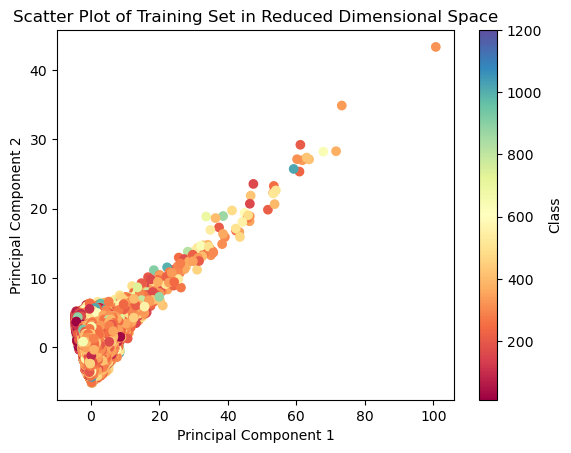

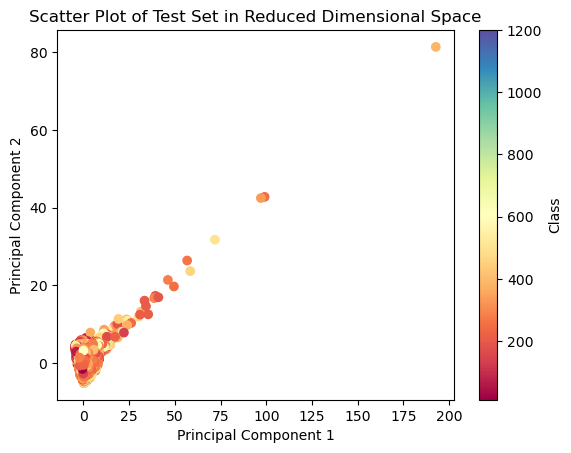

In [20]:
# Create scatter plot for training set
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.Spectral)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Training Set in Reduced Dimensional Space')
plt.colorbar(label='Class')
plt.show()

# Create scatter plot for test set
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.cm.Spectral)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Test Set in Reduced Dimensional Space')
plt.colorbar(label='Class')
plt.show();

In [ ]:
# Fit KNN classifier on reduced dimensional training set
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_var_scaled, y_train)

# Compute prediction score on reduced dimensional test set

print("Prediction score on test set:", knn.score(X_test_var_scaled, y_test))

In [ ]:
y_pred = knn1.predict(X_test_pca)

In [28]:
df = new_df.sample(frac = 0.3)
df = pd.get_dummies(df)

In [29]:
data1 = df.drop(['AttendanceTimeSeconds'],axis = 1)
target1 = df['AttendanceTimeSeconds']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data1, target1, test_size = 0.2)


In [33]:
# Instantiate the VarianceThreshold with the desired threshold
selector = VarianceThreshold(threshold=0.01)

# Fit the selector on the training data to learn the variance of each feature
selector.fit(X_train)

# Transform the training and test data based on the learned variance thresholds
X_train_var = selector.transform(X_train)
X_test_var = selector.transform(X_test)

In [34]:
# Instantiate the StandardScaler
scaler = StandardScaler()

# Normalize the original training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Normalize the variance-reduced training and test data
X_train_var_scaled = scaler.fit_transform(X_train_var)
X_test_var_scaled = scaler.transform(X_test_var)

In [36]:
# Instantiate the KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Calculate the model score on the train set
print("Train Score:", knn.score(X_train, y_train))

# Calculate the model score on the test set 
print("Test Score:", knn.score(X_test, y_test))

Train Score: 0.1567627462129496
Test Score: 0.0030208661371403244


In [38]:
# Instantiate the KNeighborsClassifier
knn_var = KNeighborsClassifier(n_neighbors=6)

# Fit the model on the training data with selected features
knn_var.fit(X_train_var, y_train)

# Calculate the model score on the selected features test set

print("Test Score with Selected Features:", knn_var.score(X_test_var, y_test))

Test Score with Selected Features: 0.0030208661371403244


In [39]:
pca = PCA()

X_train_pca = pca.fit_transform(X_train_var)  # Fit PCA on the training data


X_test_pca = pca.transform(X_test_var) 

In [40]:
# Fit KNN classifier on reduced dimensional training set
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_pca, y_train)

# Compute prediction score on reduced dimensional test set

print("Prediction score on test set:", knn.score(X_test_pca, y_test))

Prediction score on test set: 0.0030208661371403244


In [ ]:
y_pred = knn.predict(X_test_pca)

In [ ]:
#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)

#X_train_scaled = scaler.transform(X_train)


In [ ]:
knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(X_train_pca, y_train)
print("Prediction score on test set:", knn1.score(X_test_pca, y_test))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6)    # Instantiate the KNeighborsClassifier

knn_var.fit(X_train_var_, Y_train)     # Fit the model on the training data with selected features

print("Test Score with Selected Features:", knn_var.score(X_test_var, Y_test))  # Calculate the model score on the selected features test set

In [22]:
models = {'Logistic Regression': LogisticRegression(),
                  'SVM'        : SVC(),
                  'KNN'        : KNeighborsClassifier(),
           'Decision Tree'     : DecisionTreeClassifier(),
           'Random Forest'     : RandomForestClassifier()
         }

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_pca, y_train)  #train model
    
    #make prediction
    y_train_pred = model.predict(X_train_pca)
    y_test_pred = model.predict(X_test_pca)
    
    #training set performance
     
    model_train_classification = classification_report(y_train,y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train,y_train_pred)
    
    #test set performance
    model_test_classification = classification_report(y_test,y_test_pred)
    model_test_rocauc_score= roc_auc_score(y_test,y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Model performance for training set')
    print('-  classication report:  {:.4f}'.format(model_train_classification))
    print('-  Roc Auc Score:  {:.4f}'.format(model_train_rocauc_score))
    
    print('---------------------')
    
    print('Model performance for test set')
    print('-  classication report:  {:.4f}'.format(model_test_classification))
    print('-  Roc Auc Score:  {:.4f}'.format(model_test_rocauc_score))

KeyboardInterrupt: 

In [30]:
#lr = LogisticRegression()
svc = SVC()

In [ ]:
svc.fit(X_train_scaled, y_train)


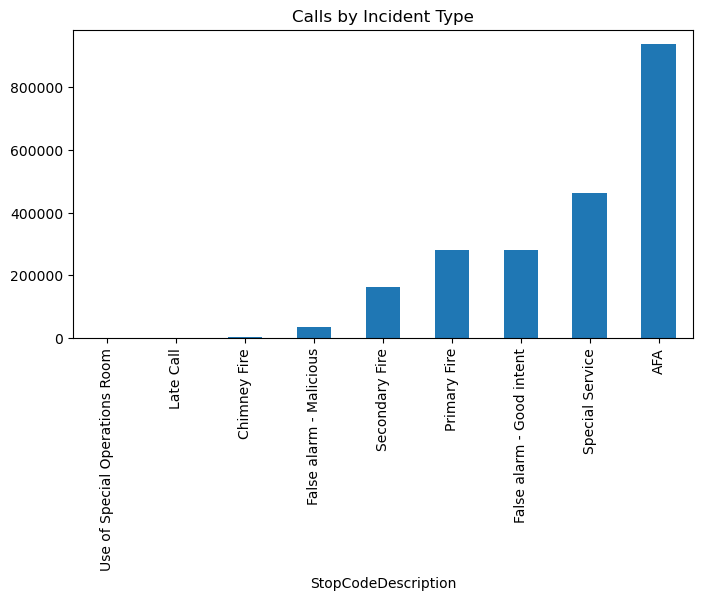

In [45]:
merged_df.groupby(['StopCodeDescription']).size().sort_values().plot(kind='bar', 
                                                                    figsize=[8,4], title='Calls by Incident Type');
#from the graph the most number of calls are from AFA.

C:\Users\User\AppData\Local\Temp\ipykernel_10128\1874507316.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(), annot = True, cmap = 'coolwarm', ax = ax);


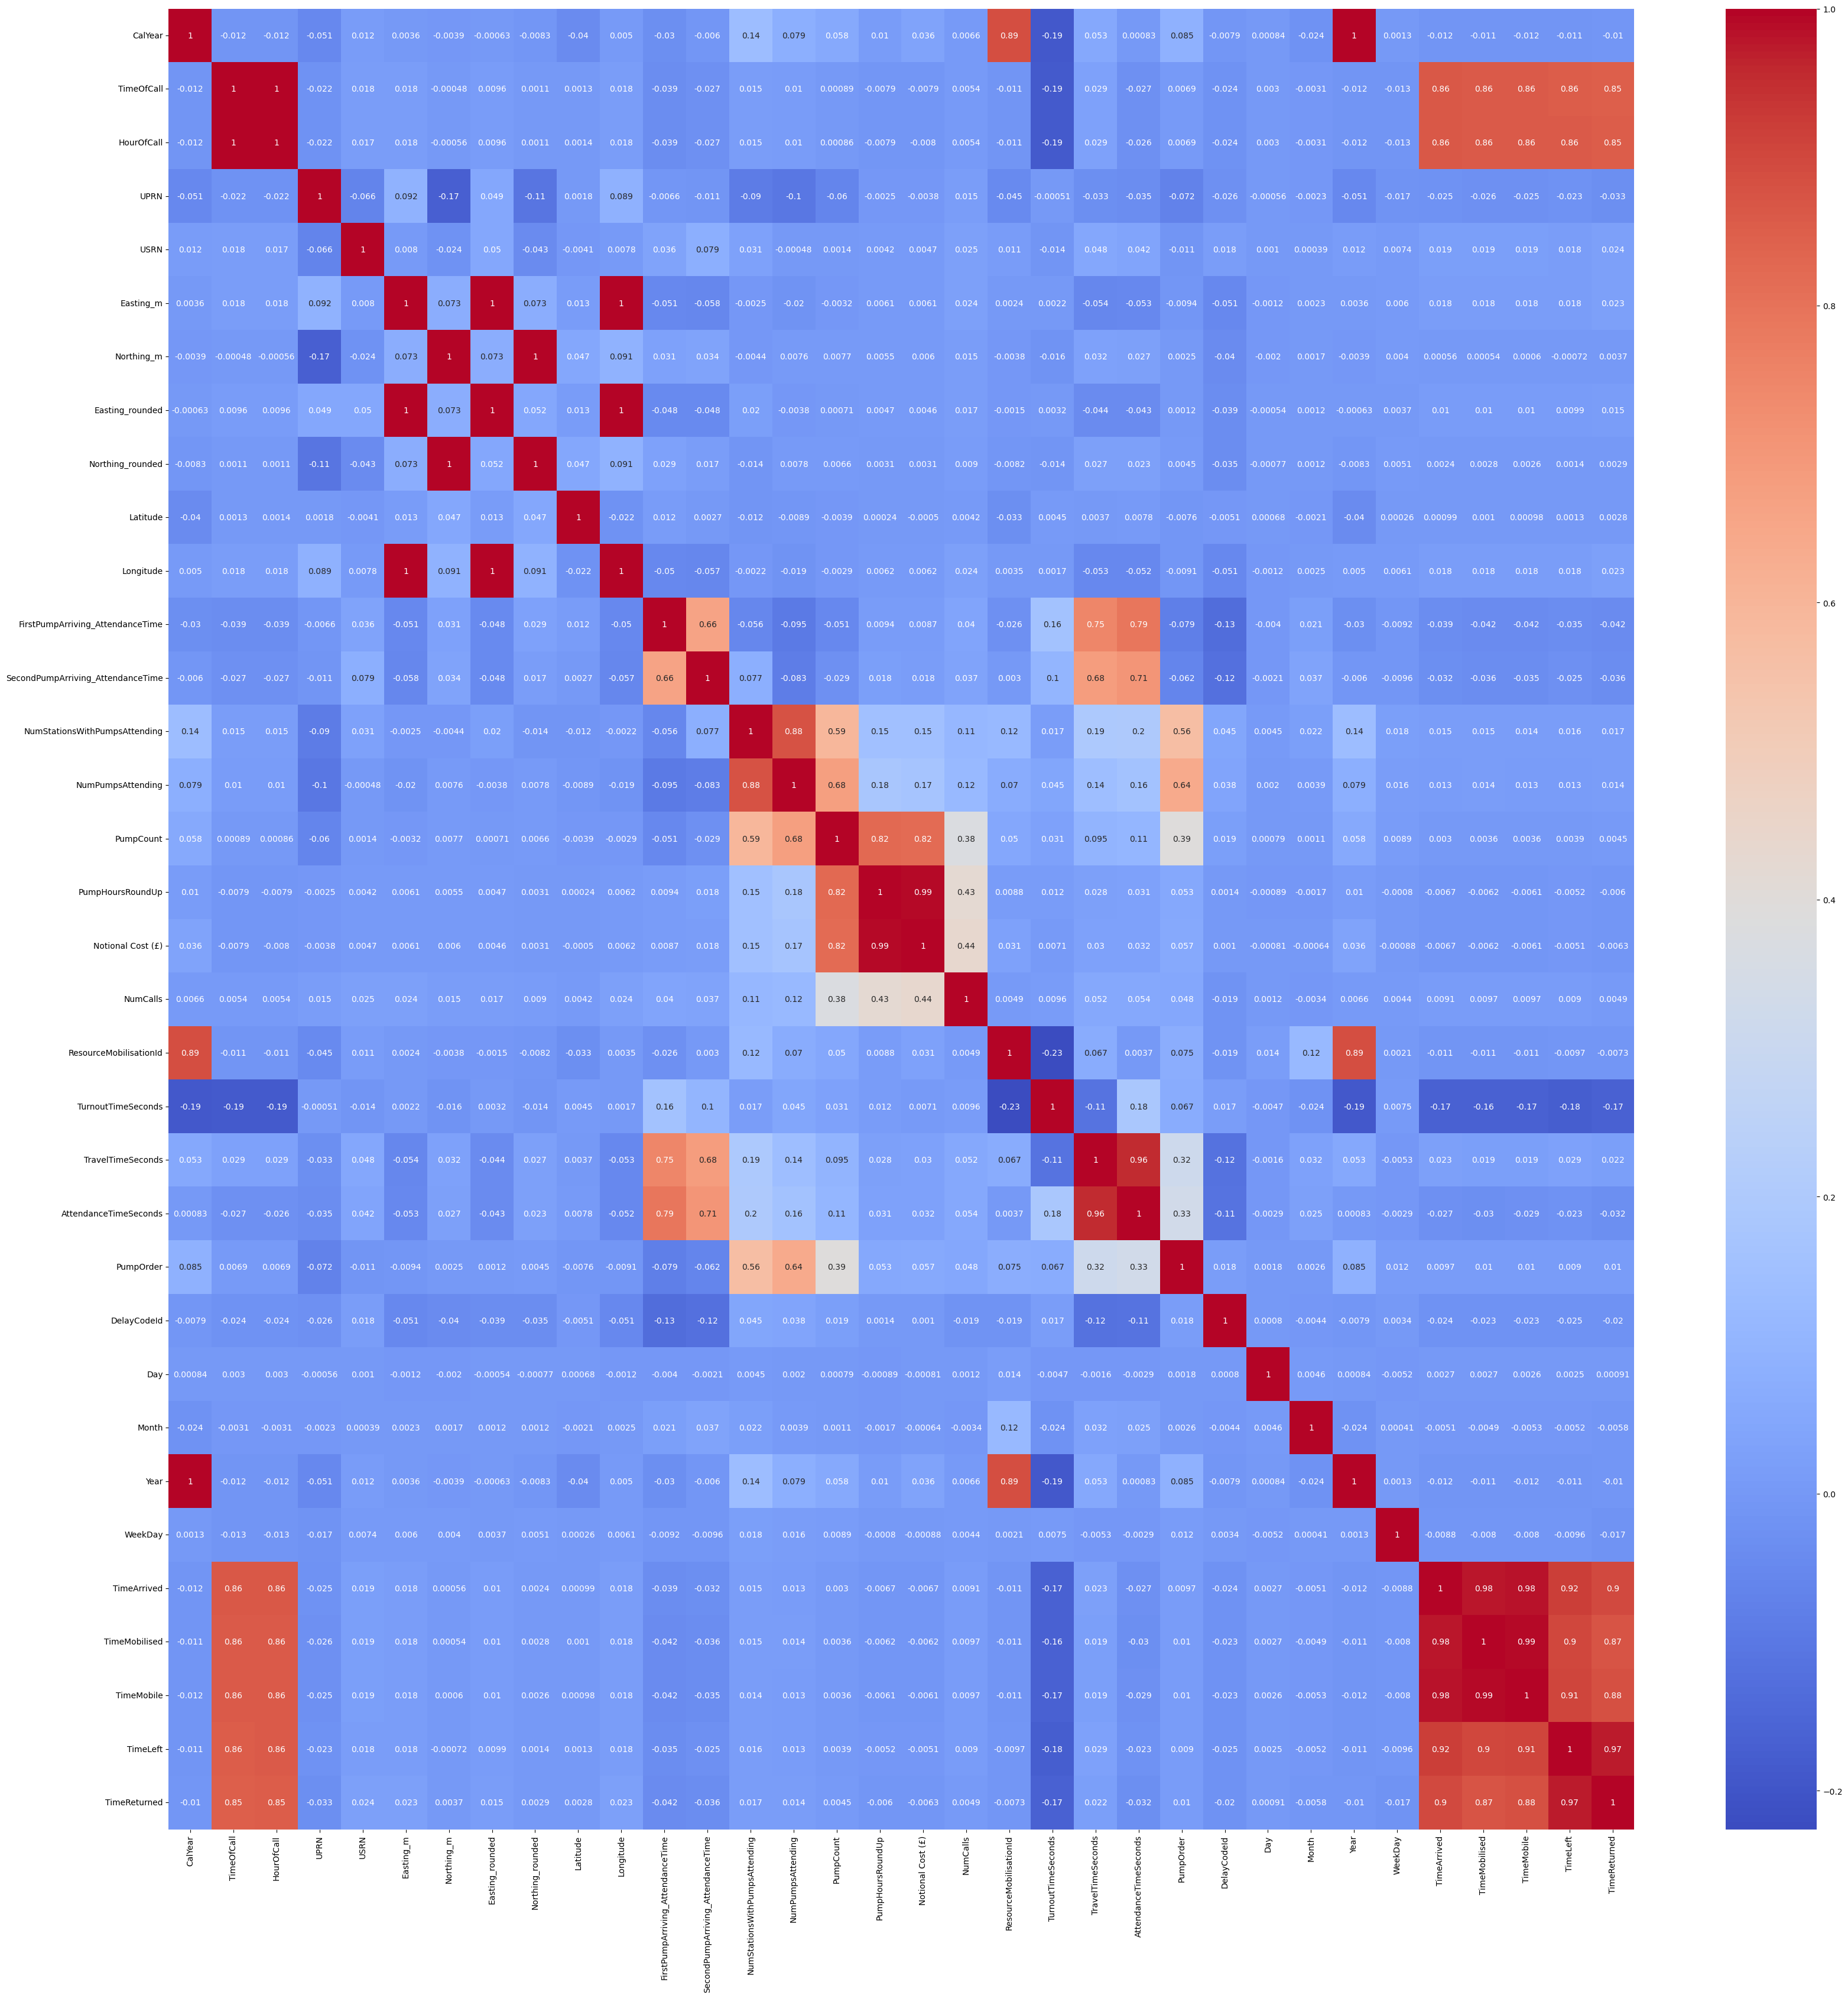

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

fig , ax = plt.subplots(figsize = (40,40))
sns.heatmap(merged_df.corr(), annot = True, cmap = 'coolwarm', ax = ax);

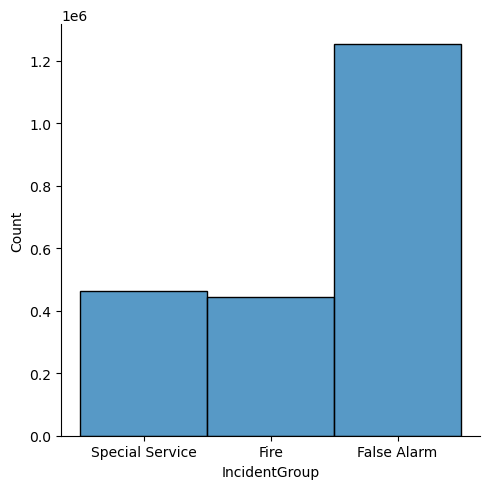

In [47]:
sns.displot(merged_df['IncidentGroup']);
# False Alarms are more than the actual service alarams

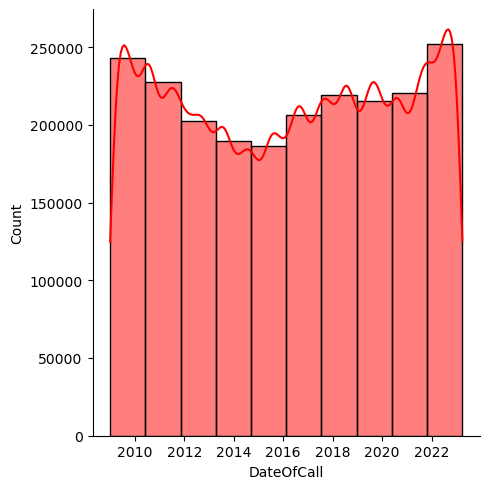

In [51]:

sns.displot(merged_df['DateOfCall'], bins = 10, kde = True, color = 'red');

In [65]:
print(merged_df['DateOfCall'].mode())
# the most frequent call is on 19th Dec, 2022

0   2022-12-19
Name: DateOfCall, dtype: datetime64[ns]


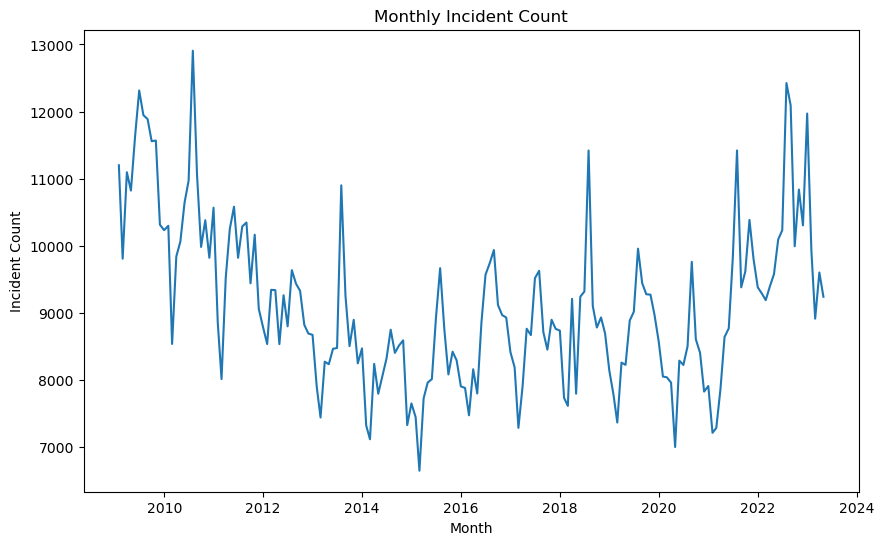

In [70]:
incidents['DateOfCall']=pd.to_datetime(incidents['DateOfCall'])
monthly_incidents = incidents.groupby(pd.Grouper(key='DateOfCall', freq='M')).size()
plt.figure(figsize=(10, 6))
plt.plot(monthly_incidents.index, monthly_incidents.values)
plt.xlabel('Month')
plt.ylabel('Incident Count')
plt.title('Monthly Incident Count')
plt.show();

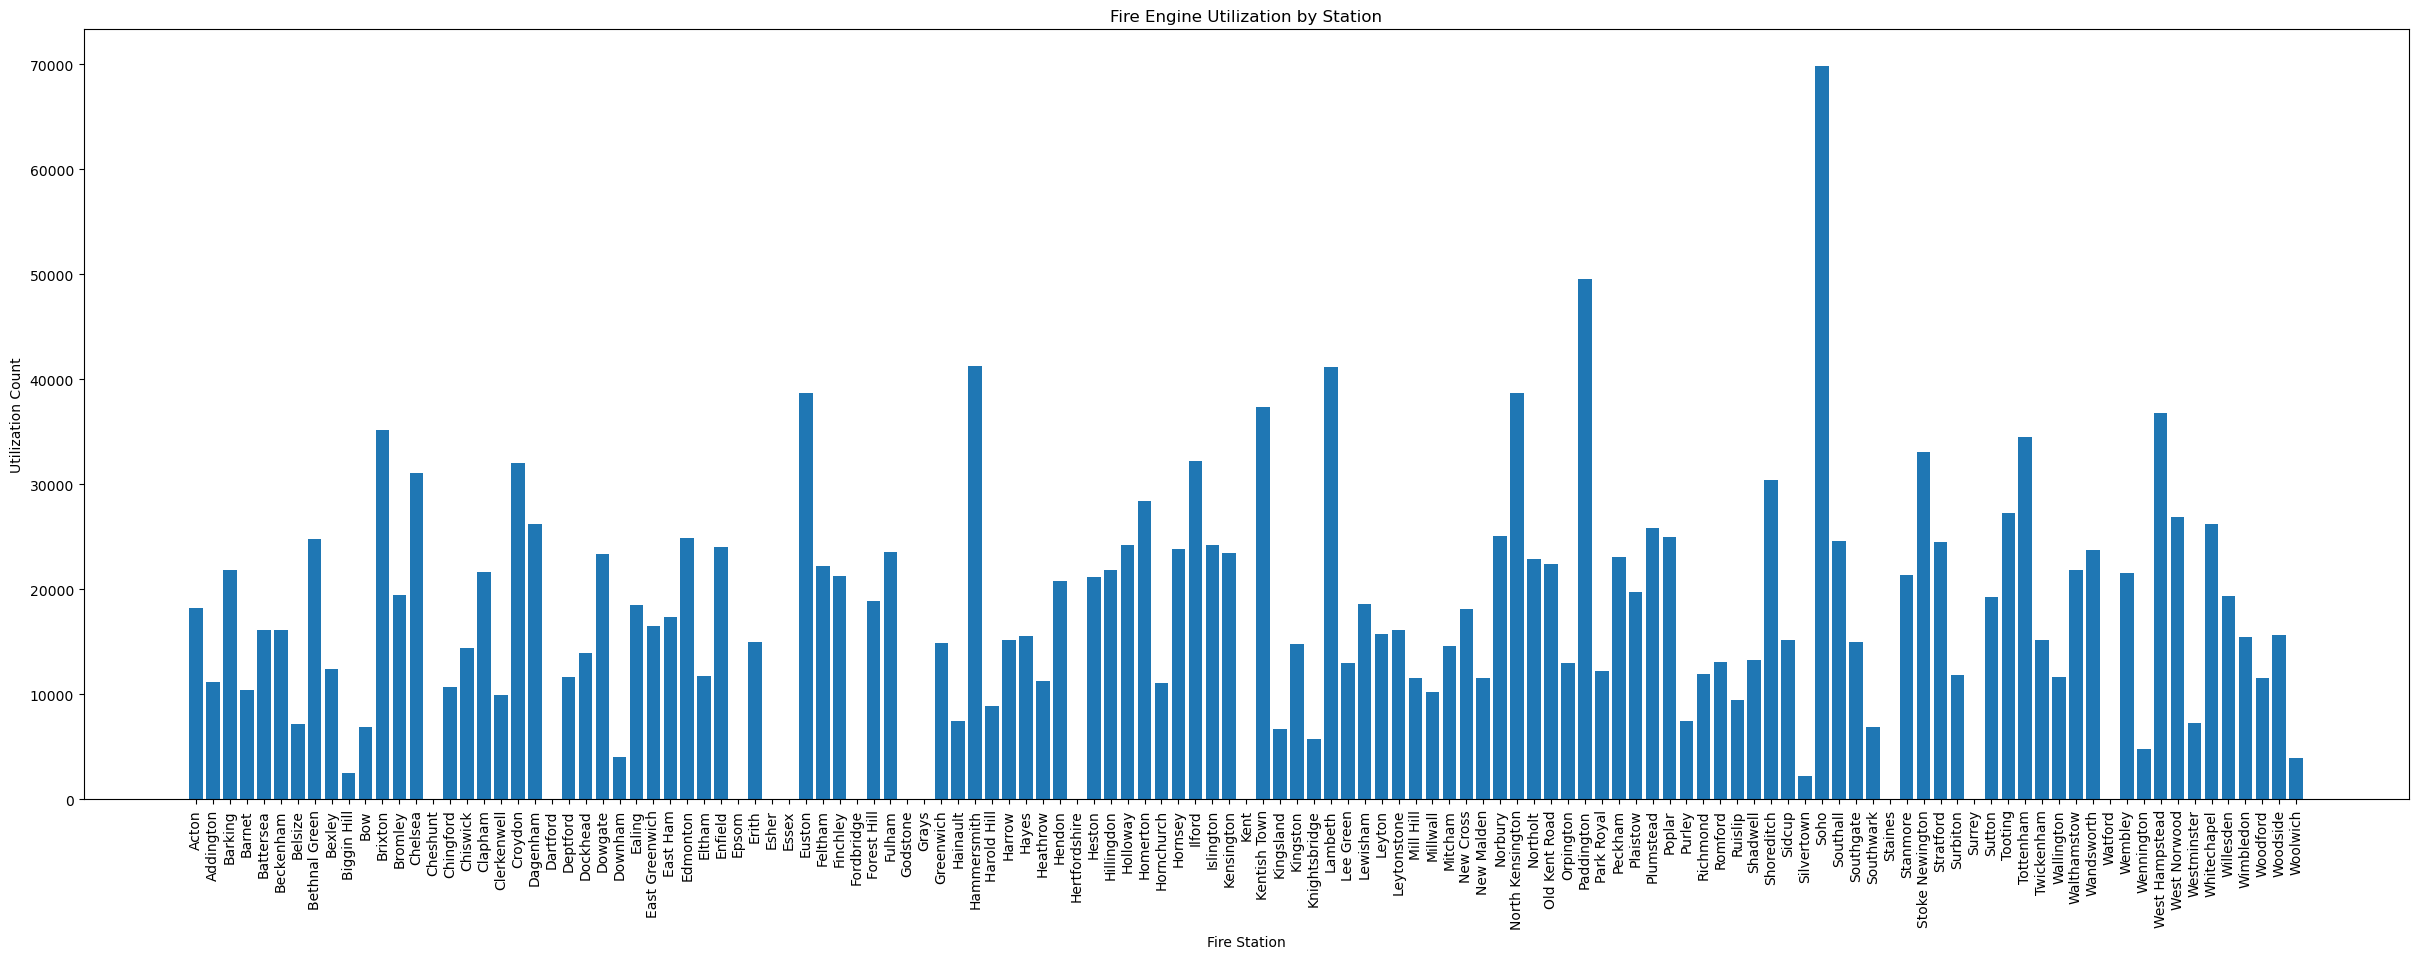

In [83]:
utilization_by_station = mobilize.groupby('DeployedFromStation_Name').size()
plt.figure(figsize=(30, 10))
plt.bar(utilization_by_station.index, utilization_by_station.values)
plt.xlabel('Fire Station')
plt.ylabel('Utilization Count')
plt.title('Fire Engine Utilization by Station')
plt.xticks(rotation=90);

# Here we are displaying the utilization count of fire engines by station, according to graph fire station with name SOHO has 
#more utilization count than any other 

In [4]:
from scipy.stats import chi2_contingency

observed = pd.crosstab(incidents['StopCodeDescription'], incidents['PropertyType'])
result = chi2_contingency(observed)


print("Chi-square statistic: ", result[0])
print("P-value:", result[1])
print('\n\nHere p-value is below a chosen significance level (e.g., 0.05)')
print(' we can reject the null hypothesis and conclude that there is a significant association between StopCodeDescription and PropertyType')

Chi-square statistic:  2015048.6975207177
P-value: 0.0


Here p-value is below a chosen significance level (e.g., 0.05)
 we can reject the null hypothesis and conclude that there is a significant association between StopCodeDescription and PropertyType


In [5]:
# Perform ANOVA
## 1 - Hypotheses :
# H0 : There is no significant relationship between the "TurnoutTime" variable and 
#the two factors,"resourceCode" and "DeployedFromLocation.
# H1 : There is a significant relationship between the "TurnoutTime" variable and 
#the two factors, "resourceCode" and "DeployedFromLocation


import statsmodels.api as sm
from statsmodels.formula.api import ols
 

result = ols('TurnoutTimeSeconds ~ Resource_Code + DeployedFromLocation', data= mobilize).fit()
anova_table = sm.stats.anova_lm(result)

# Print the ANOVA table
print(anova_table)
# 3 - Conclusion : 
# p-val < 5% 
# It can be concluded that there is a significant relationship between the "TurnoutTime" variable and 
#the two factors, "resourceCode" and "DeployedFromLocation




                             df        sum_sq       mean_sq           F  \
Resource_Code             186.0  9.657756e+07  5.192342e+05  264.253007   
DeployedFromLocation        1.0  1.529183e+06  1.529183e+06  778.244397   
Residual              2138785.0  4.202527e+09  1.964913e+03         NaN   

                             PR(>F)  
Resource_Code          0.000000e+00  
DeployedFromLocation  3.111858e-171  
Residual                        NaN  


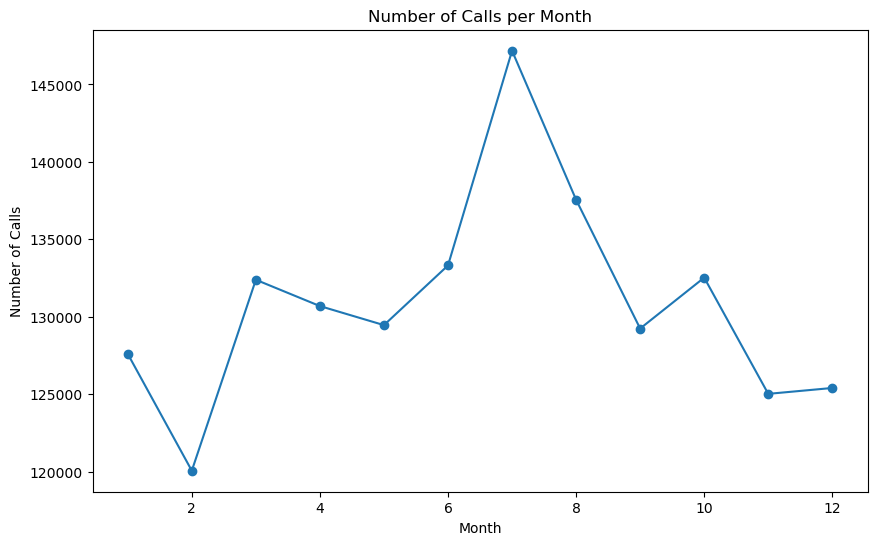

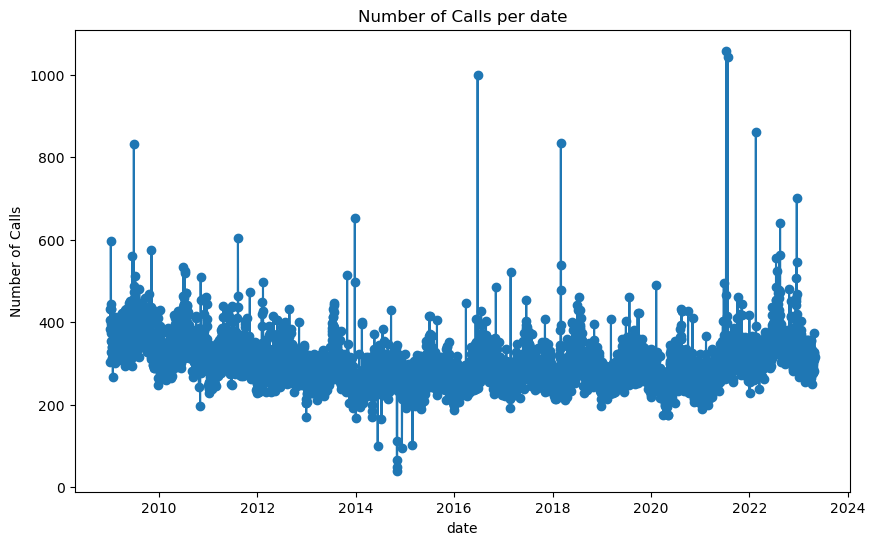

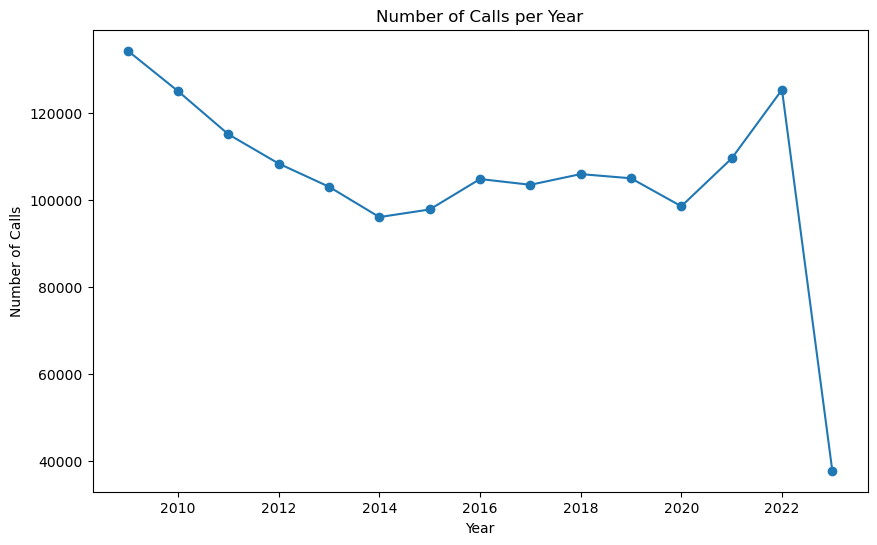

In [9]:
import matplotlib.pyplot as plt
# Convert the 'dateofcall' column to datetime format
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'])

# Extract month, hour, and year from the 'DateOfCall' column
incidents['month'] = incidents['DateOfCall'].dt.month
incidents['date'] = incidents['DateOfCall'].dt.date
incidents['year'] = incidents['DateOfCall'].dt.year

# Plot the number of calls per month
calls_per_month = incidents.groupby('month').size()
plt.figure(figsize=(10, 6))
plt.plot(calls_per_month.index, calls_per_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Month')
plt.show()

# Plot the number of calls per date
calls_per_date = incidents.groupby('date').size()
plt.figure(figsize=(10, 6))
plt.plot(calls_per_date.index, calls_per_date.values, marker='o')
plt.xlabel('date')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per date')
plt.show()

# Plot the number of calls per year
calls_per_year = incidents.groupby('year').size()
plt.figure(figsize=(10, 6))
plt.plot(calls_per_year.index, calls_per_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Calls')
plt.title('Number of Calls per Year')
plt.show()

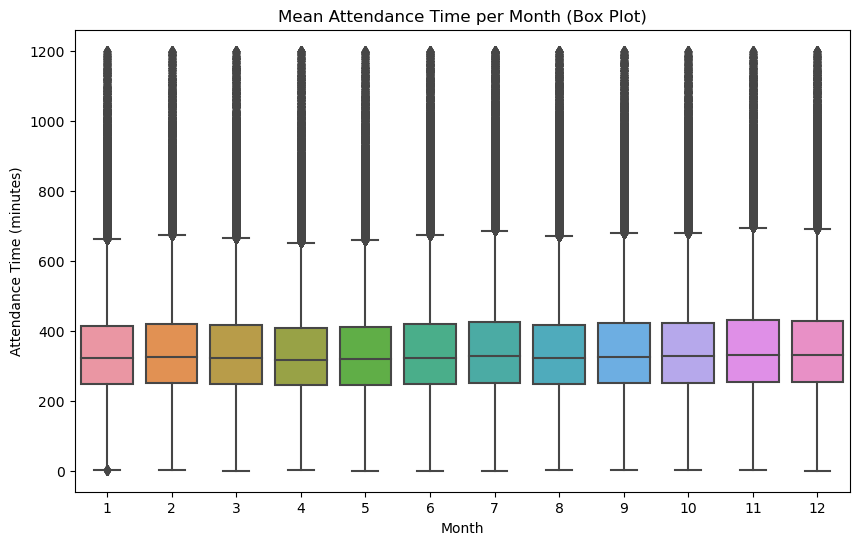

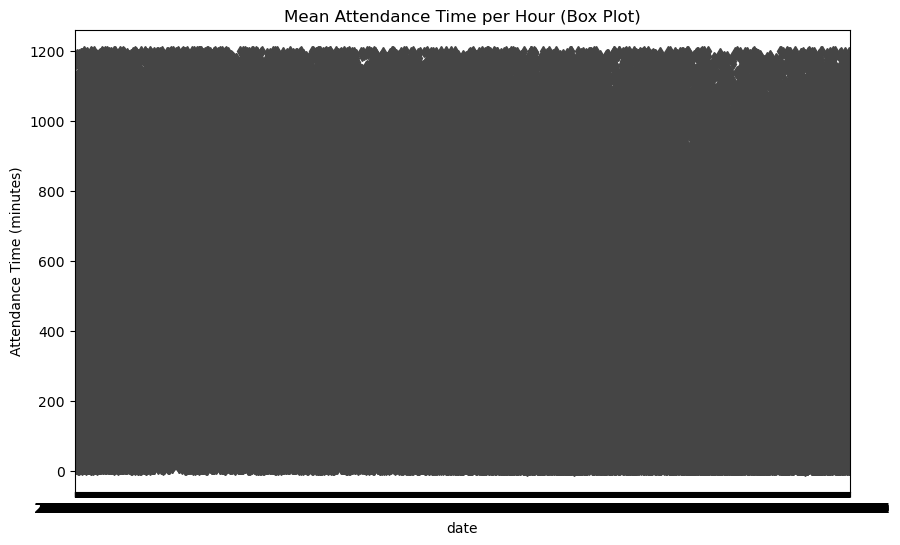

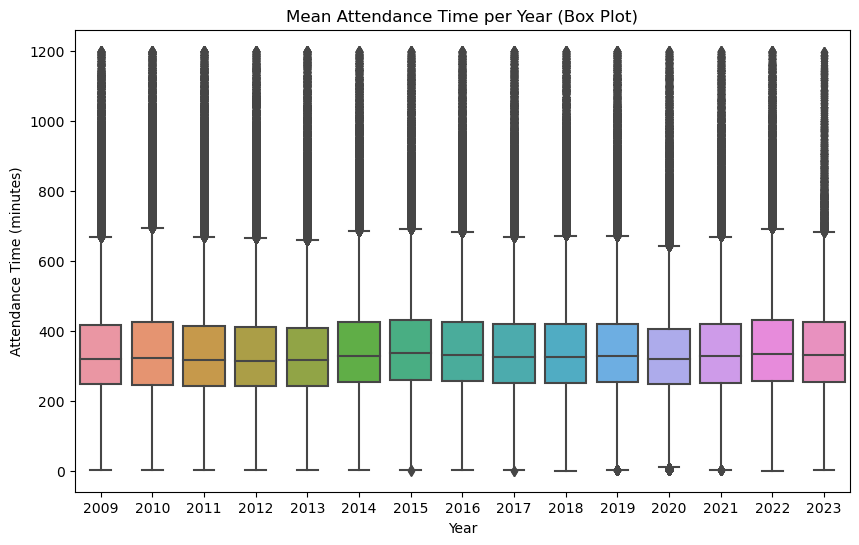

In [15]:
import seaborn as sns
# Convert the 'dateofcall' column to datetime format
merged_df['DateOfCall'] = pd.to_datetime(merged_df['DateOfCall'])

# Extract month, hour, and year from the 'DateOfCall' column
merged_df['month'] = merged_df['DateOfCall'].dt.month
merged_df['date'] = merged_df['DateOfCall'].dt.date
merged_df['year'] = merged_df['DateOfCall'].dt.year

# Plot the mean attendance time per month using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['month'], y=merged_df['AttendanceTimeSeconds'])
plt.xlabel('Month')
plt.ylabel('Attendance Time (minutes)')
plt.title('Mean Attendance Time per Month (Box Plot)')
plt.show()

# Plot the mean attendance time per hour using a box plot
##plt.figure(figsize=(10, 6))
#sns.boxplot(x=merged_df['date'], y=merged_df['AttendanceTimeSeconds'])
#plt.xlabel('date')
#plt.ylabel('Attendance Time (minutes)')
#plt.title('Mean Attendance Time per Hour (Box Plot)')
#plt.show()

# Plot the mean attendance time per year using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df['year'], y=merged_df['AttendanceTimeSeconds'])
plt.xlabel('Year')
plt.ylabel('Attendance Time (minutes)')
plt.title('Mean Attendance Time per Year (Box Plot)')
plt.show()

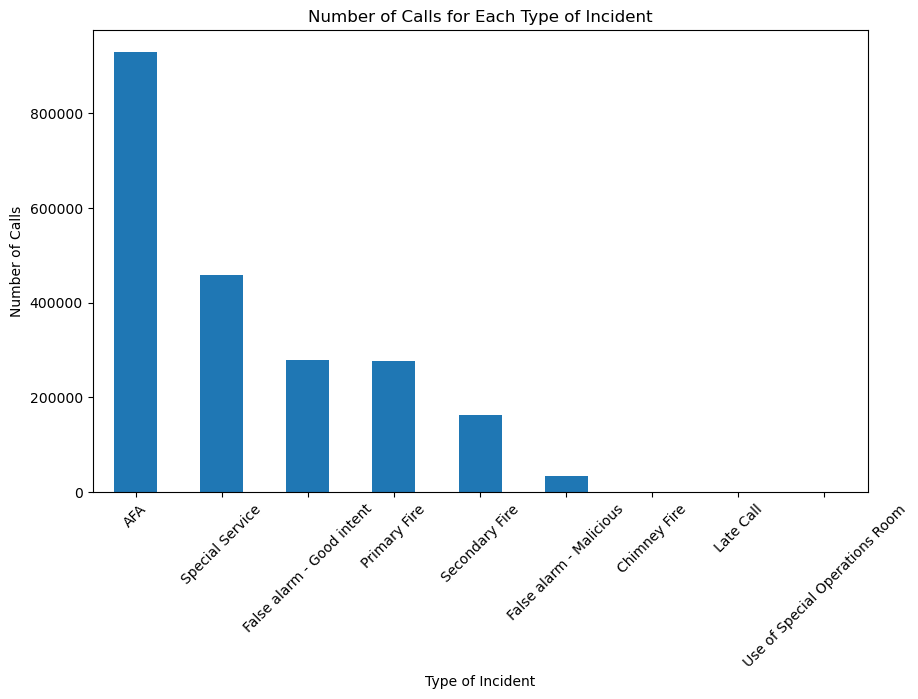

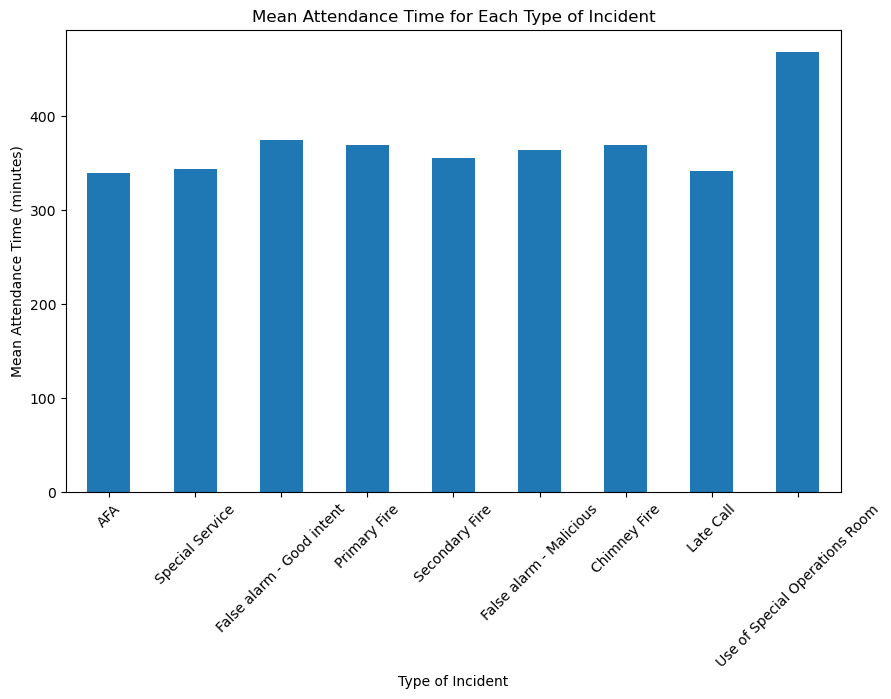

In [16]:
# Group the dataset by the type of incident and calculate the count of calls and mean attendance time
merged_df_summary = merged_df.groupby('StopCodeDescription').agg({'IncidentNumber': 'count', 'AttendanceTimeSeconds': 'mean'})
merged_df_summary  = merged_df_summary .rename(columns={'IncidentNumber': 'Number of Calls', 'AttendanceTimeSeconds': 'Mean Attendance Time'})

# Sort the summary dataframe by the number of calls in descending order
merged_df_summary  = merged_df_summary .sort_values('Number of Calls', ascending=False)

# Plot the count of calls for each type of incident
plt.figure(figsize=(10, 6))
merged_df_summary ['Number of Calls'].plot(kind='bar')
plt.xlabel('Type of Incident')
plt.ylabel('Number of Calls')
plt.title('Number of Calls for Each Type of Incident')
plt.xticks(rotation=45)
plt.show()

# Plot the mean attendance time for each type of incident
plt.figure(figsize=(10, 6))
merged_df_summary ['Mean Attendance Time'].plot(kind='bar')
plt.xlabel('Type of Incident')
plt.ylabel('Mean Attendance Time (minutes)')
plt.title('Mean Attendance Time for Each Type of Incident')
plt.xticks(rotation=45)
plt.show()